# BMM via the changepoint kernel: the master notebook

## Author: Alexandra Semposki

### Date last edited: 01 March 2025

---

The MASTER notebook that runs everything except the TOV for this project. Now with mock HIC data and mock FRG data capabilities, and the greedy algorithm implementation of these.

In [322]:
# do NOT rerun this cell if running greedy algorithm
new_pts = []

hic_counter = 0 

---
---

In [441]:
# hic data use (run second run if using greedy algorithm)
hic_data = True

if hic_data is True:
    if len(new_pts) == 1:
        hic_counter += 1
        
print(hic_counter)

1


---
---


In [442]:
# define if using mean function or not
mean_function = True

if mean_function is False:
    type_mean = '0'
else:
    type_mean = 'spline'

---

In [443]:
# larger error bars in FRG data
larger_errors = False

# cutoff of chiral EFT data
chiral_cutoff = False

# for plotting efficiency
if chiral_cutoff is True:
    chiral_location = 'nsat'
else:
    chiral_location = '2'

---

In [444]:
number = len(new_pts)
print(number)

3


In [445]:
# cutoff parameter moves up here for clarity
cutoff = 20

In [446]:
# type of changepoint kernel switching function
switch = 'sigmoid'

---

In [447]:
# print these for clarity
print('===Settings===')
print('\nData points:', number)
print('\nMean function:', type_mean)
print('\nChiral cutoff:', chiral_location)
print('\npQCD cutoff: {} n0'.format(cutoff))
print('\nLarge data errors:', larger_errors)
print('\nChangepoint kernel: {}'.format(switch))

===Settings===

Data points: 3

Mean function: spline

Chiral cutoff: 2

pQCD cutoff: 20 n0

Large data errors: False

Changepoint kernel: sigmoid


---

In [448]:
# import needed packages
%load_ext autoreload
%autoreload 2

import sys
import arviz as az
sys.path.append('../src/')
import scipy as sp
from scipy.linalg import block_diag
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

from gp_utils import GaussianProcessRegressor2dNoise
from custom_kernels import SigmoidChangepoint, TanhChangepoint
from eos_utils import *
from tov_utils import *
from scripts import *
from pqcd_reworked import PQCD
from data_utils import log_full_spline

import sys
sys.path.append('../../../TOV_Solver')
from TOV_class import TOVsolver

# set params for plotting
setup_rc_params()

# define saturation up here
n0 = 0.164

# color plotting assistance
orders = [0, 1, 2, 3]
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

## Setting up the training data <a id="setup"></a>

Load in the data sets from $\chi$EFT and perturbative QCD.

In [449]:
data_xeft = np.load('../data/NSM_data/chiral_nsm_scaled.npz')
data_pqcd = np.load('../data/eos_data/pressure_pqcd_data_scaled_NSM.npz')

In [450]:
# call frg function
from data_utils import frg_greedy_data  # scale = 1.3 usually
frg_data, lowercontour, uppercontour = frg_greedy_data(plot=False, larger_errors=larger_errors, scale=1.3)

In [451]:
# select training points to use 
data_xeft_2 = {
    'density': data_xeft['density'][::2],
    'mean': data_xeft['mean'][::2],
    'std_dev': data_xeft['std_dev'][::2],
    'cov': data_xeft['cov'][::2,::2]
    
}

chiral_tr_data, pqcd_tr_data, training_data_new = gp_data(data_xeft_2, data_pqcd, cutoff, \
                                                          all_orders=False, matter='ANM')

# delete some of the elements to keep some extra points
nope = [0, 4, 6]

# cut these out
chiral_data = {}
chiral_data['dens'] = np.delete(chiral_tr_data['dens'], nope, 0)
chiral_data['mean'] = np.delete(chiral_tr_data['mean'], nope, 0)
chiral_data['std'] = np.delete(chiral_tr_data['std'], nope, 0)
chiral_data['cov'] = np.delete(np.delete(chiral_tr_data['cov'], nope, 0), nope, 1)

# assign testing array (no equal points in training)
density_test = np.linspace(0.05, 16.4, 900)[:-1]

(8,) (8,) (8,) (8, 8)
(8,) (8,) (8,) (8, 8)
(7,) (7,) (7,) (7, 7)
Cov shape: (15, 15)


In [452]:
# unscaling interpolation function (needed for the HIC data)
convert_pqcd = np.load('../data/eos_data/pqcd_fg_data_NSM.npz')

# interpolate for a functional form to use 
convert_interp = sp.interpolate.interp1d(convert_pqcd['density'], convert_pqcd['mean'], \
                                 kind='cubic', fill_value='extrapolate')
gp_cs2_convert_arr = convert_interp(density_test)

# HIC data point for use later
dens_hic = 0.41  # fm^-3
pres_hic = 40.0  # MeV/fm^3
std_hic =  5.0    # MeV/fm^3
cov_hic =  std_hic**2.0  # variance of the HIC data
scaled_std_hic = std_hic / convert_interp(dens_hic)
scaled_hic = pres_hic / convert_interp(dens_hic)

In [453]:
# make training data out of the first set
chiral_tr_finalish = {
    'dens': chiral_tr_data['dens'][1::2],
    'mean': chiral_tr_data['mean'][1::2],
    'std': chiral_tr_data['std'][1::2],
    'cov': chiral_tr_data['cov'][1::2,1::2]
}

# if chiral_cutoff works
if chiral_cutoff is True:
    nope2x = [-1,-2, -3, -4]
    chiral_tr_final = {
        'dens': np.delete(chiral_tr_data['dens'], nope2x, 0),
        'mean': np.delete(chiral_tr_data['mean'], nope2x, 0),
        'std': np.delete(chiral_tr_data['std'], nope2x, 0),
        'cov': np.delete(np.delete(chiral_tr_data['cov'], nope2x, 0), nope2x, 1)
    }
else:
    chiral_tr_final = chiral_tr_finalish

In [454]:
pqcd_tr_final = {
    'dens': pqcd_tr_data['dens'],
    'mean': pqcd_tr_data['mean'],
    'std': pqcd_tr_data['std'],
    'cov': pqcd_tr_data['cov']
}

# if no mock data, use the original training set with no fRG data included
if len(new_pts) == 0:
    training_data_2 = {
        'dens': np.concatenate((chiral_tr_final['dens'], pqcd_tr_final['dens'])),
        'mean': np.concatenate((chiral_tr_final['mean'], pqcd_tr_final['mean'])),
        'std': np.concatenate((chiral_tr_final['std'], pqcd_tr_final['std'])),
        'cov': block_diag(chiral_tr_final['cov'], pqcd_tr_final['cov'])
    }
    
else:
    if hic_data is False:
        print('Using new data set from previous run.')
        training_data_2 = {
            'dens': np.concatenate((chiral_tr_final['dens'], new_pts, pqcd_tr_final['dens'])),
            'mean': np.concatenate((chiral_tr_final['mean'], frg_mean, pqcd_tr_final['mean'])),
            'std': np.concatenate((chiral_tr_final['std'], frg_std, pqcd_tr_final['std'])),
            'cov': block_diag(chiral_tr_final['cov'], frg_cov, pqcd_tr_final['cov'])
        }
    else:
        print('Using HIC data point and new data set from previous run.')
        training_data_2 = {
            'dens': np.concatenate((chiral_tr_final['dens'], new_pts, pqcd_tr_final['dens'])),
            'mean': np.concatenate((chiral_tr_final['mean'], frg_mean, pqcd_tr_final['mean'])),
            'std': np.concatenate((chiral_tr_final['std'], frg_std, pqcd_tr_final['std'])),
            'cov': block_diag(chiral_tr_final['cov'], frg_cov, pqcd_tr_final['cov'])
        }

# print training data for Table II results
print('\nDensity: \n', training_data_2['dens'])
print('\nMean: \n', training_data_2['mean'])
print('\nStd dev: \n', training_data_2['std'])

Using HIC data point and new data set from previous run.

Density: 
 [ 0.09357262  0.17103506  0.2484975   0.32595993  0.41        0.85022247
  0.66835373  3.29816361  5.48180301  7.6654424   9.8490818  12.0327212
 14.2163606  16.4       ]

Mean: 
 [0.04384642 0.10521407 0.19189235 0.26642541 0.41365735 0.76301507
 0.64343164 1.12216728 1.10108283 1.09103381 1.08485423 1.0805493
 1.07731912 1.07477293]

Std dev: 
 [0.00439573 0.01597702 0.03677041 0.07065512 0.05170717 0.08373079
 0.06575572 0.03371912 0.02196701 0.01726267 0.01465635 0.0129697
 0.01177373 0.01087309]


In [455]:
errorbar_kwargs_2 = dict(
    capsize=3,
    ecolor="k",
    ls="none",
    marker="*",
    markerfacecolor="k",
    markeredgecolor="k",
    markersize=8,
)

errorbar_kwargs_frg = dict(
    capsize=3,
    ecolor="k",
    ls="none",
    marker="o",
    markerfacecolor="k",
    markeredgecolor="k",
    markersize=3
)

In [456]:
# chiral EFT data 
n_xeft = data_xeft['density']
p_mean_xeft = data_xeft['mean']
p_stdv_xeft = data_xeft['std_dev']
p_cov_xeft = data_xeft['cov']

# get the pqcd curve to only plot greater than the cutoff choice
ind_cut = np.where(data_pqcd['density']/n0 >= cutoff)[0][0]

# pQCD data
n_pqcd = data_pqcd['density'][ind_cut:]
p_mean_pqcd = data_pqcd['mean'][ind_cut:, -1]
p_stdv_pqcd = data_pqcd['std_dev'][ind_cut:, -1]
p_cov_pqcd = data_pqcd['cov'][ind_cut:, ind_cut:, -1]

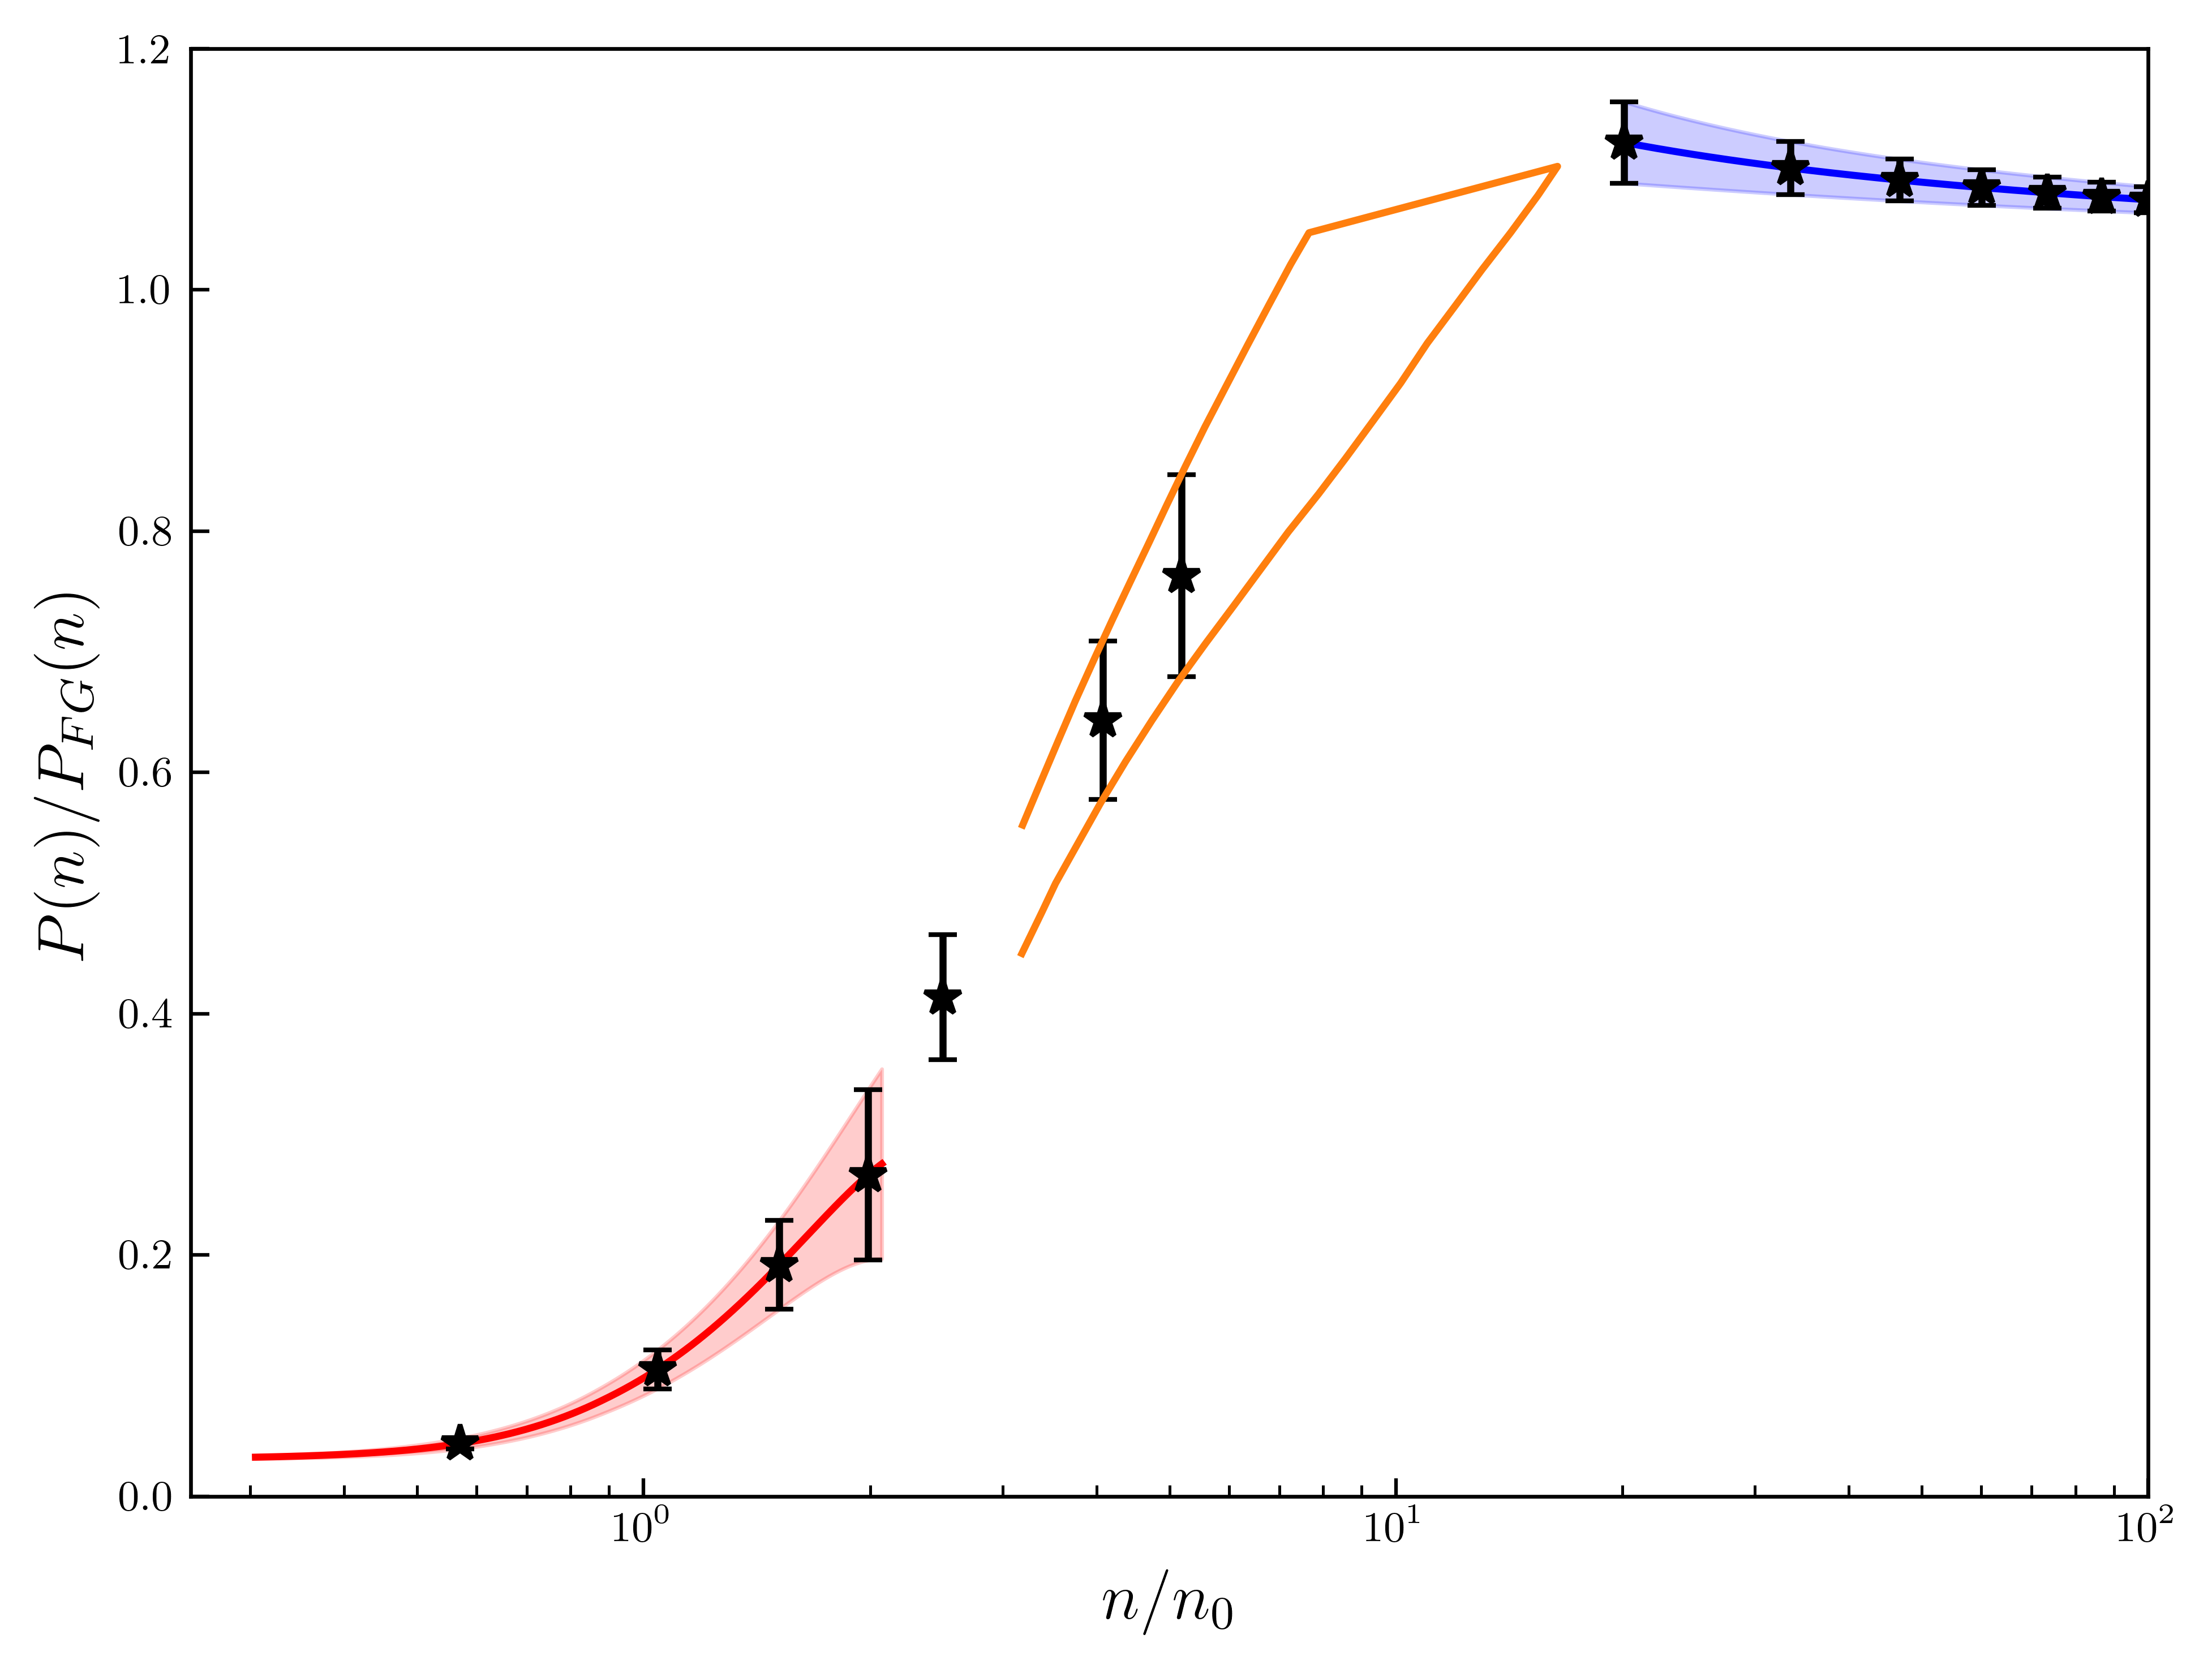

In [457]:
# plot the current data sets
fig, ax = plt.subplots(dpi=600)
ax: Axes
color_xeft = "red"
color_xeft_2 = 'green'
color_pqcd = "blue"
ax.set_xlim(0.25, 100.0)
ax.set_ylim(0, 1.2)
ax.set_xscale('log')
ax.set_ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)
ax.set_xlabel(r'$n/n_{0}$', fontsize=14)

# result of idea 1
ax.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N3LO)')
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, \
                alpha=0.2, color=color_xeft)
ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)

ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N2LO)')
ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)

# FRG mock data pool being used
df_frg = pd.read_csv('../data/frg_data_pressure.csv')
plt.plot(df_frg['n/n0'], 1.3*df_frg['P/P_free'])

plt.show()

## Mean function choices

Here we wish to design a mean function that will help us test whether the choice of the mean function affects our overall result when training on FRG data in the intermediate region.

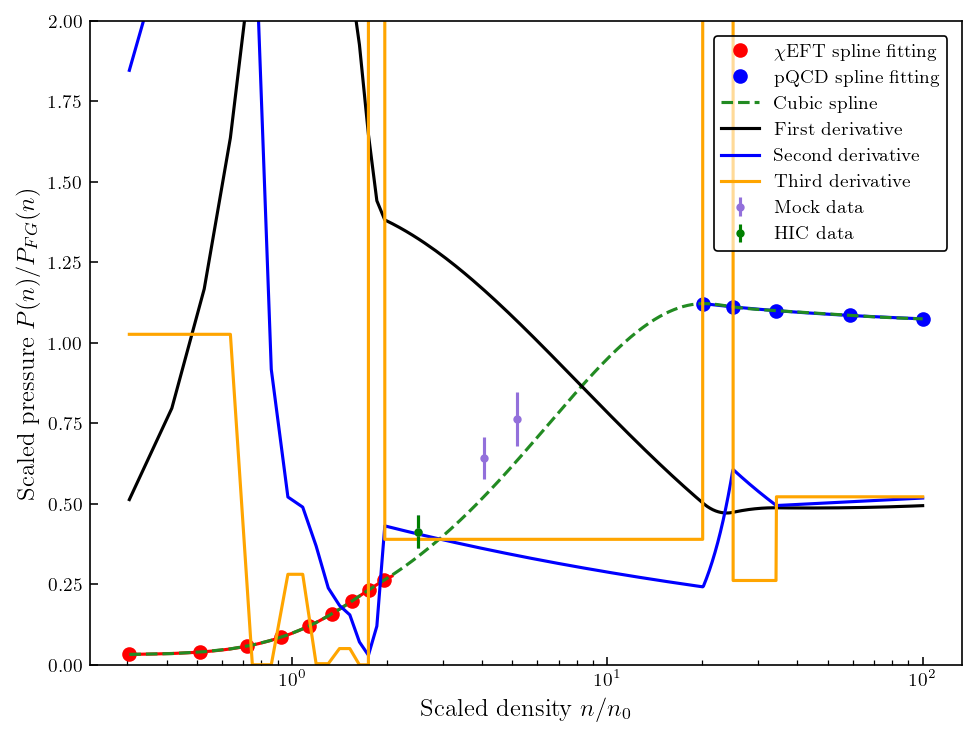

In [458]:
if mean_function is True:
    
    # interpolate the data
    p_interp_xeft = interp1d(n_xeft, p_mean_xeft, fill_value='extrapolate')
    p_interp_pqcd = interp1d(n_pqcd, p_mean_pqcd, fill_value='extrapolate')
    
    # make a point at 20n0, and then one at 30n0 and then very large spaces between 40n0 and 100n0
    new_point = 4.1  # fm^-3
    y_new_point = p_interp_pqcd(new_point)
    
    # log space pQCD
    log_min_pqcd = np.log(n_pqcd[0])
    log_max_pqcd = np.log(n_pqcd[-1])
    log_pqcd_grid = np.linspace(log_min_pqcd, log_max_pqcd, 4)
    pqcd_grid = np.exp(log_pqcd_grid)
    pqcd_mean_grid = p_interp_pqcd(pqcd_grid)
    
    # insert the one stupid point into the "list"
    pqcd_grid = pqcd_grid.tolist()
    pqcd_grid.insert(1, new_point)
    pqcd_grid = np.array(pqcd_grid)
    pqcd_mean_grid = pqcd_mean_grid.tolist()
    pqcd_mean_grid.insert(1, y_new_point)
    pqcd_mean_grid = np.array(pqcd_mean_grid)
    
    # print (what the hell)
    total_dens = np.concatenate((n_xeft[::70], pqcd_grid))
    total_data = np.concatenate((p_mean_xeft[::70], pqcd_mean_grid))

    # create scaled data here
    y_scaled = training_data_2['mean'] - np.exp(log_full_spline(total_dens, \
                                                                      total_data, training_data_2['dens']))    

    # test the derivatives
    spline_result, deriv_dict = log_full_spline(total_dens, total_data, density_test, deriv_eval=True)
    
    # test via plotting
    plt.plot(n_xeft[::70]/n0, p_mean_xeft[::70], marker='o', linestyle=' ',\
             color='red', label=r'$\chi$EFT spline fitting')
    #plt.plot(xeft_grid/n0, xeft_mean_grid, marker='o', linestyle=' ', \
    #color='red', label=r'$\chi$EFT spline fitting')
    plt.plot(pqcd_grid/n0, pqcd_mean_grid, marker='o', linestyle=' ', \
             color='blue', label=r'pQCD spline fitting')
    plt.plot(n_xeft/n0, p_mean_xeft, color='red')
    plt.plot(n_pqcd/n0, p_mean_pqcd, color='blue')
    
    plt.plot(density_test/n0, np.exp(log_full_spline(total_dens, \
                                                        total_data, density_test)), \
            color='forestgreen', linestyle='dashed', label=r'Cubic spline')
    
    # derivs
    plt.plot(density_test/n0, 0.5*np.exp(deriv_dict['1']), color='black', label='First derivative')
    plt.plot(density_test/n0, 0.5*np.exp(deriv_dict['2']), color='blue', label=r'Second derivative')
    plt.plot(density_test/n0, 0.5*np.exp(deriv_dict['3']), color='orange', label=r'Third derivative')
    
    if len(new_pts) != 0:
        plt.errorbar(np.asarray(new_pts)/n0, frg_mean, frg_std, marker='.', \
                     linestyle=' ', color='mediumpurple', label=r'Mock data')
    if hic_data is True:
        plt.errorbar(dens_hic/n0, scaled_hic, scaled_std_hic, marker='.', \
                     linestyle=' ', color='green', label=r'HIC data')
    plt.ylim(0.,2.)
    plt.xscale('log')
    plt.xlabel(r'Scaled density $n/n_{0}$', fontsize=12)
    plt.ylabel(r'Scaled pressure $P(n)/P_{FG}(n)$', fontsize=12)
    plt.legend()
    plt.show()

---
---

## GP representations of $\chi$EFT and pQCD 

0.949**2 * RBF(length_scale=0.31)


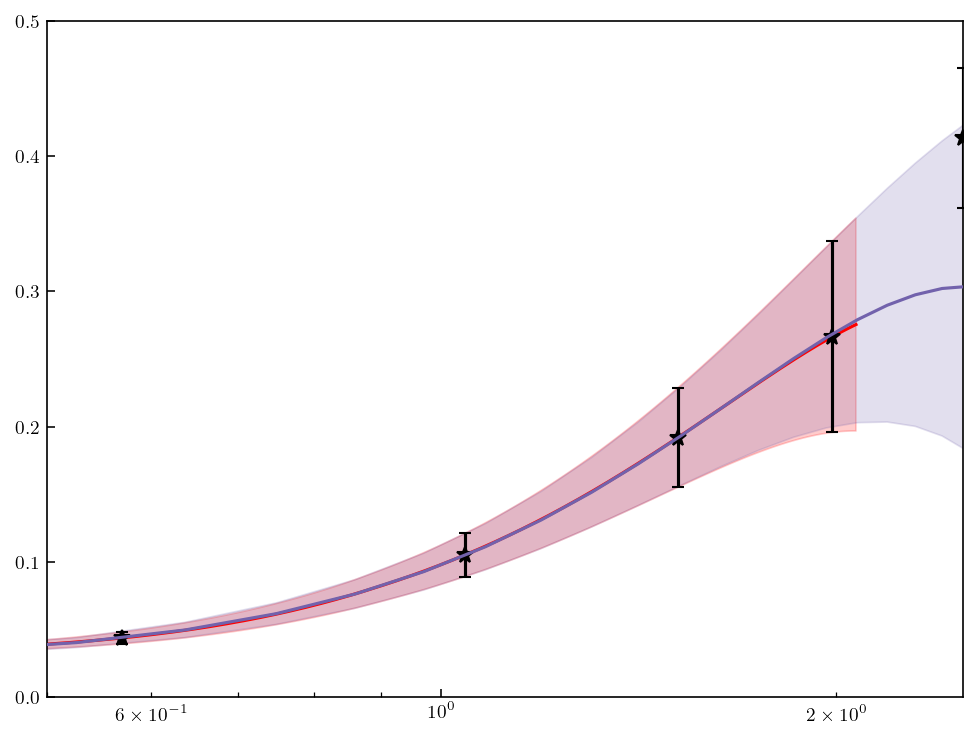

Approx. % error at n0:  7.06
Approx. % error at 0.5n0:  -8.82


In [459]:
# trial and error optimal length scales and variances (expand to variable quantities?)
if chiral_cutoff is False:
    chiral_cbar = 0.9
    chiral_ls = 0.31
    k_chi = (C(constant_value=chiral_cbar, constant_value_bounds='fixed') \
             * RBF(length_scale=chiral_ls, length_scale_bounds='fixed'))
else:
    chiral_cbar = 0.9
    chiral_ls = 0.25
    k_chi = (C(constant_value=chiral_cbar, constant_value_bounds='fixed') \
             * RBF(length_scale=chiral_ls, length_scale_bounds='fixed'))

# chiral EFT
gp = GaussianProcessRegressor2dNoise(
    kernel=k_chi,
    alpha = chiral_tr_final['cov'],
)

gp.fit(chiral_tr_final['dens'].reshape(-1,1), chiral_tr_final['mean'].reshape(-1,1))

print(gp.kernel_)

chi_predict, chi_std_predict = gp.predict(density_test.reshape(-1,1), return_std=True)
_, chi_cov_predict = gp.predict(density_test.reshape(-1,1), return_cov=True)

# plot the result quickly to test
plt.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N3LO)')
plt.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, \
                alpha=0.2, color=color_xeft)
plt.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)
plt.plot(density_test/n0, chi_predict, color=colors[2], zorder=10)
plt.fill_between(density_test/n0, chi_predict-chi_std_predict, chi_predict+chi_std_predict, \
                 color=colors[2], alpha=0.2)

if chiral_cutoff is True:
    plt.ylim(0.0, 0.15)
    plt.xlim(0.5, 1.1)
else:
    plt.ylim(0.0, 0.5)
    plt.xlim(0.5, 2.5)
plt.xscale('log')
plt.show()

# check standard deviation difference at n0 or so (important for both chiral cutoffs)
ind_chi = np.where([density_test[i] <= 0.164 for i in range(len(density_test))])[0][-1]
ind_chi_data = np.where([n_xeft[i] >= 0.164 for i in range(len(n_xeft))])[0][0]
dens_band = n_xeft[ind_chi_data]
std_band = p_stdv_xeft[ind_chi_data]
gp_band = chi_std_predict[ind_chi]

# double checking at 0.5 n0 to be sure
ind_chi_2 = np.where([density_test[i] >= 0.082 for i in range(len(density_test))])[0][0]
ind_chi_data_2 = np.where([n_xeft[i] >= 0.082 for i in range(len(n_xeft))])[0][0]
dens_band_2 = n_xeft[ind_chi_data_2]
std_band_2 = p_stdv_xeft[ind_chi_data_2]
gp_band_2 = chi_std_predict[ind_chi_2]

print('Approx. % error at n0: ', round((std_band - gp_band)/std_band*100, 2))
print('Approx. % error at 0.5n0: ', round((std_band_2 - gp_band_2)/std_band_2*100, 2))

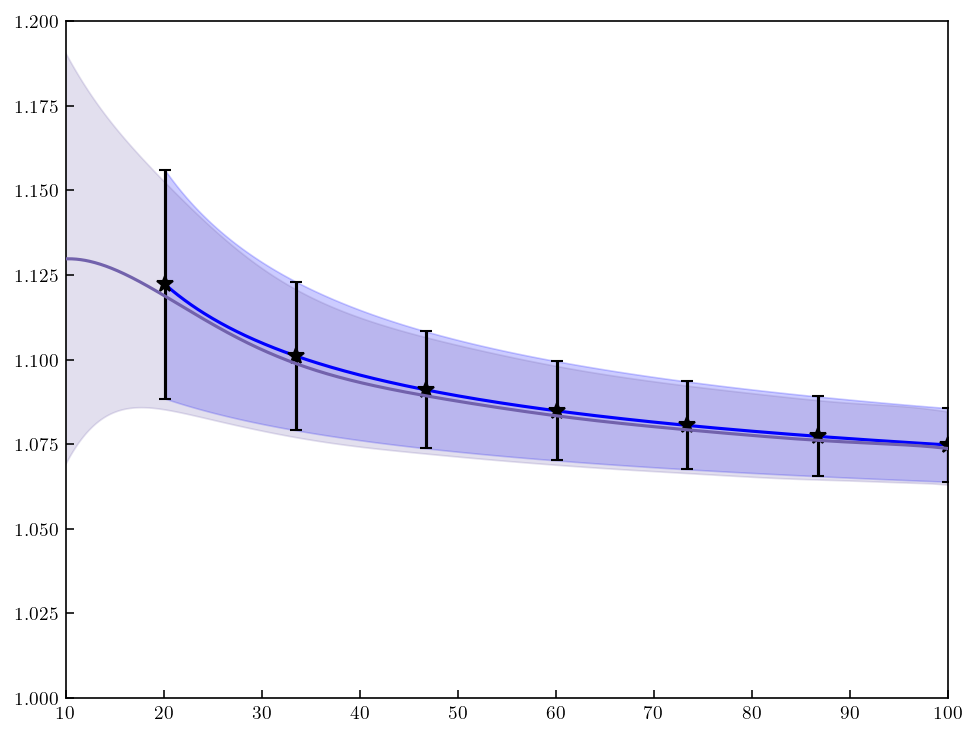

In [460]:
# now we're going to attempt to fit pQCD
if cutoff == 20:
    pqcd_cbar = 1.0
    pqcd_ls = 5.0
    k_pqcd = (C(constant_value=pqcd_cbar, constant_value_bounds='fixed') \
              * RBF(length_scale=pqcd_ls, length_scale_bounds='fixed'))
elif cutoff == 40:
    pqcd_cbar = 1.0
    pqcd_ls = 10.0
    k_pqcd = (C(constant_value=pqcd_cbar, constant_value_bounds='fixed') \
              * RBF(length_scale=pqcd_ls, length_scale_bounds='fixed'))

# chiral EFT
gp2 = GaussianProcessRegressor2dNoise(
    kernel=k_pqcd,
    alpha = pqcd_tr_final['cov'],
)

gp2.fit(pqcd_tr_final['dens'].reshape(-1,1), pqcd_tr_final['mean'].reshape(-1,1), priors=False, \
        prior_choice='truncnorm_15')

pqcd_predict, pqcd_std_predict = gp2.predict(density_test.reshape(-1,1), return_std=True)
_, pqcd_cov_predict = gp2.predict(density_test.reshape(-1,1), return_cov=True)

# plot the result quickly to test
plt.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N2LO)')
plt.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)
plt.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)
plt.plot(density_test/n0, pqcd_predict, color=colors[2], zorder=10)
plt.fill_between(density_test/n0, pqcd_predict-pqcd_std_predict, pqcd_predict+pqcd_std_predict, \
                 color=colors[2], alpha=0.2)
plt.ylim(1.0, 1.2)
plt.xlim(10.0, 100.0)
#plt.xscale('log')
plt.show()

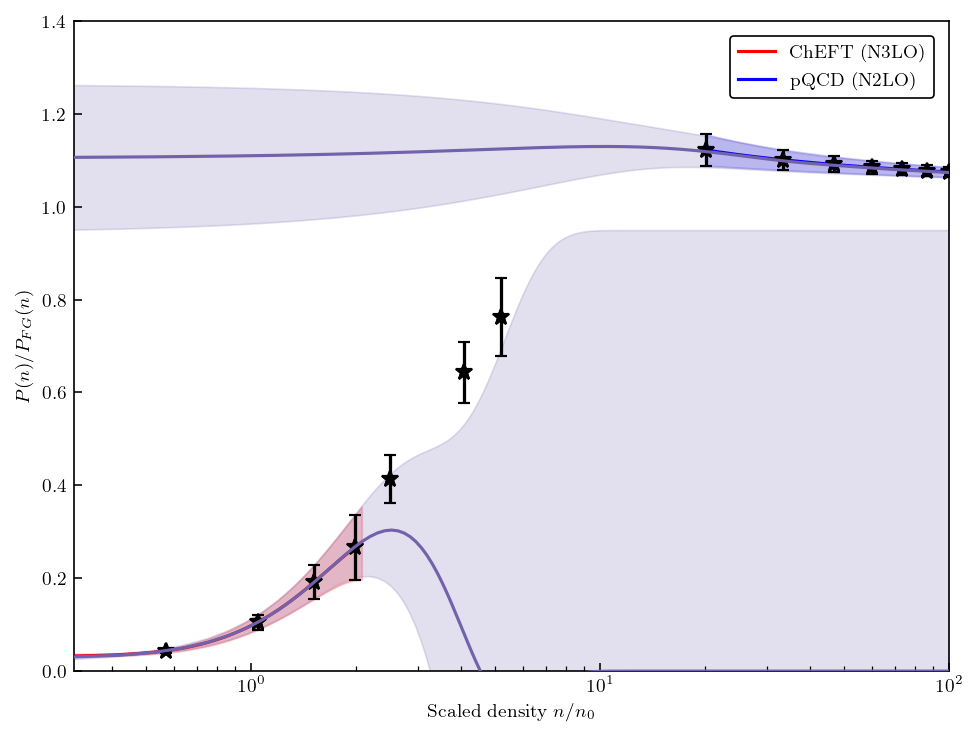

In [461]:
# check the plotting of both of these together, see what they look like
plt.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N3LO)')
plt.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, \
                alpha=0.2, color=color_xeft)
plt.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)
plt.plot(density_test/n0, chi_predict, color=colors[2], zorder=10)
plt.fill_between(density_test/n0, chi_predict-chi_std_predict, chi_predict+chi_std_predict, \
                 color=colors[2], alpha=0.2)
plt.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N2LO)')
plt.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)
plt.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)
plt.plot(density_test/n0, pqcd_predict, color=colors[2], zorder=10)
plt.fill_between(density_test/n0, pqcd_predict-pqcd_std_predict, \
                 pqcd_predict+pqcd_std_predict, color=colors[2], alpha=0.2)
plt.ylim(0.0, 1.4)
plt.xlim(0.31, 100.0)
plt.xscale('log')
plt.legend()
plt.xlabel(r'Scaled density $n/n_0$')
plt.ylabel(r'$P(n)/P_{FG}(n)$')
plt.show()

---
---

## Calculation of $P(n)$ using a changepoint kernel  <a id="calc_p_n"></a>

Now we construct the kernel we wish to use, which is the changepoint kernel. 

$$
k(x_i, x_j) = (1 - \sigma(x_i)) k_{1}(x_i,x_j) (1 - \sigma(x_j)) + \sigma(x_i) k_{2}(x_i, x_j) \sigma(x_j),
$$

where, for our initial test case, $k_{1}$, $k_{2}$ are the RBF kernel, and $\sigma$ are, here, sigmoid functions, given as

$$
\sigma(x) = \frac{1}{1 + \exp(-(x-x_{c})/k)}.
$$ 

(__Note__: In the code we also have the tanh function as a switching function, which is written as
$$
\sigma(x) = \frac{1}{2} + \frac{1}{2}\tanh((x-x_{c})/k),
$$
possessing the same two parameters as the sigmoid function, described below.)


The changepoint is determined within the sigmoid function as $x_{c}$, along with a width parameter $k$ that will describe the slope of the function about the changepoint location. These are two parameters that will need to be optimized in the full training of the kernel---we will be attempting this after fixing them and testing that scenario first. The RBF kernels will both be trained on the individual data in each region, and let extrapolate until the changepoint.

This will first be coded manually and checked for accuracy, then will be coded into the `sklearn` workflow.

### BMM using a changepoint kernel with a switching function

In [462]:
# kernel
if cutoff == 20:
    if switch == 'sigmoid':
        kernel = SigmoidChangepoint(ls1=chiral_ls, ls2=pqcd_ls, cbar1=chiral_cbar, cbar2=pqcd_cbar, changepoint=0.9, \
                             changepoint_bounds=[0.488, 3.12], width=0.16, width_bounds=[0.05, 0.32])  # 1.476
#         kernel = SigmoidChangepoint(ls1=chiral_ls, ls2=pqcd_ls, cbar1=chiral_cbar, cbar2=pqcd_cbar, changepoint=0.9, \
#                              changepoint_bounds='fixed', width=0.16, width_bounds=[0.05, 0.32])  # 1.476
    elif switch == 'tanh':
        kernel = TanhChangepoint(ls1=chiral_ls, ls2=pqcd_ls, cbar1=chiral_cbar, cbar2=pqcd_cbar, changepoint=0.9, \
                             changepoint_bounds=[0.488, 3.12], width=0.31, width_bounds=[0.05, 0.64])  # 1.476
#          kernel = TanhChangepoint(ls1=chiral_ls, ls2=pqcd_ls, cbar1=chiral_cbar, cbar2=pqcd_cbar, changepoint=0.9, \
#                              changepoint_bounds='fixed', width=0.32, width_bounds=[0.1, 0.64])  # 1.476

elif cutoff == 40:
    if switch == 'sigmoid':
        kernel = SigmoidChangepoint(ls1=chiral_ls, ls2=pqcd_ls, cbar1=chiral_cbar, cbar2=pqcd_cbar, changepoint=0.9, \
                             changepoint_bounds=[0.488, 6.24], width=0.16, width_bounds=[0.05, 0.32])  # 1.476
    elif switch == 'tanh':
        kernel = TanhChangepoint(ls1=chiral_ls, ls2=pqcd_ls, cbar1=chiral_cbar, cbar2=pqcd_cbar, changepoint=0.9, \
                             changepoint_bounds=[0.488, 6.24], width=0.31, width_bounds=[0.1, 0.64])  # 1.476

# set up the GPR object
gpcp = GaussianProcessRegressor2dNoise(kernel=kernel, alpha=training_data_2['cov'] , 
                                       n_restarts_optimizer=10000)

In [463]:
# train the kernel (though we really don't need to, we need to fit)
X_train = training_data_2['dens'].reshape(-1,1)

if mean_function is True:
    y_train = y_scaled.reshape(-1,1)
else:
    y_train = training_data_2['mean'].reshape(-1,1)
    
prior_dict = {
    'w': 'truncnorm',
    'cp': 'truncnorm',
    'switch': switch,
}

gpcp.fit(X_train, y_train, priors=True, prior_choice='changepoint', prior_type = prior_dict, \
         switch=switch, cutoff=cutoff)
print(gpcp.kernel_)

/Users/alexandra/Documents/EOSBMM/buqeyenm/notebooks/../src/gp_utils.py:827: UserWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  warnings.warn(warning_msg) #ConvergenceWarning, stacklevel=2)  # commenting out for now (should investigate!)


SigmoidChangepoint(changepoint=0.488, width=0.227)


Value of maximum likelihood changepoint: 0.27272727272727276
Value from the GP regression: 0.488


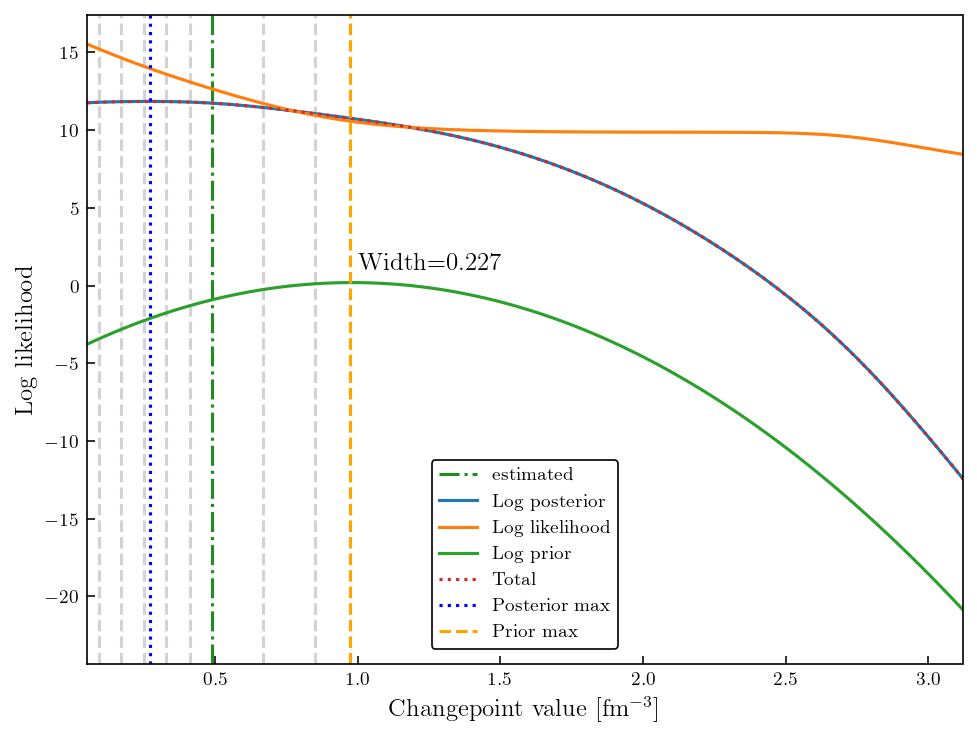

In [464]:
log_likelihood = []
test_cp = np.linspace(0.05, 3.2, 100)
width= round(np.exp(gpcp.kernel_.theta[1]), 3)

logprior = []
loglikelihood = []
for cp in test_cp:
    if switch == 'sigmoid':
        kernel = SigmoidChangepoint(ls1=chiral_ls, ls2=pqcd_ls, cbar1=chiral_cbar, cbar2=pqcd_cbar, 
                         changepoint=cp, changepoint_bounds=[cp-0.0001, cp+0.0001], \
                             width=width, width_bounds='fixed')
    elif switch == 'tanh':
        kernel = TanhChangepoint(ls1=chiral_ls, ls2=pqcd_ls, cbar1=chiral_cbar, cbar2=pqcd_cbar, 
                         changepoint=cp, changepoint_bounds=[cp-0.0001, cp+0.0001], \
                             width=width, width_bounds='fixed')
    gpcptest = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data_2['cov']  # here is where we input the full covariance matrix from the data
    )
    gpcptest.fit(X_train, y_train, priors=True, prior_choice='changepoint', \
                 prior_type=prior_dict, switch=switch, cutoff=cutoff)
    log_likelihood.append(gpcptest.log_marginal_likelihood())
    train_matrix = gpcptest.K_copy
    loglikelihood.append(gpcptest.log_likelihood)
    logprior.append(gpcptest.log_prior)
    
ind = np.where([np.asarray(log_likelihood[i]) >= max(log_likelihood) \
                for i in range(len(log_likelihood))])[0][-1]
ind_prior = np.where([np.asarray(logprior[i]) >= max(logprior) for i in range(len(logprior))])[0][-1]
cp_final = round(np.exp(gpcp.kernel_.theta[0]), 3)
w_final = round(np.exp(gpcp.kernel_.theta[1]), 3)

# print some values to check
print('Value of maximum likelihood changepoint: {}'.format(test_cp[ind]))
print('Value from the GP regression: {}'.format(cp_final))  # this looks great

#plt.xscale('log')
[plt.axvline(x=training_data_2['dens'][i], linestyle='dashed', color='lightgray') \
 for i in range(len(training_data_2['dens']))]
plt.axvline(x=cp_final, linestyle='-.', label='estimated', color='forestgreen')  

# plot the changepoint result
plt.plot(test_cp, log_likelihood, label=r'Log posterior')
plt.plot(test_cp, loglikelihood, label=r'Log likelihood')
plt.plot(test_cp, logprior, label=r'Log prior')
plt.plot(test_cp, np.asarray(loglikelihood)+np.asarray(logprior), label=r'Total', linestyle='dotted')
plt.axvline(x=test_cp[ind], linestyle='dotted', label=r'Posterior max', color='blue')
plt.axvline(x=test_cp[ind_prior], linestyle='dashed', label=r'Prior max', color='orange')

# rest of plot
plt.xlabel(r'Changepoint value [fm$^{-3}$]', fontsize=12)
#plt.xlim(0.488, 3.12)
plt.xlim(0.05, 3.12)
plt.text(1.0, 1.0, 'Width={}'.format(width), fontsize=12)
plt.ylabel('Log likelihood', fontsize=12)
plt.legend()
#plt.plot(test_cp, np.gradient(loglikelihood, test_cp, edge_order=2))

Value of width at maximum log likelihood: 0.24409090909090908
Value from regression: 0.4881


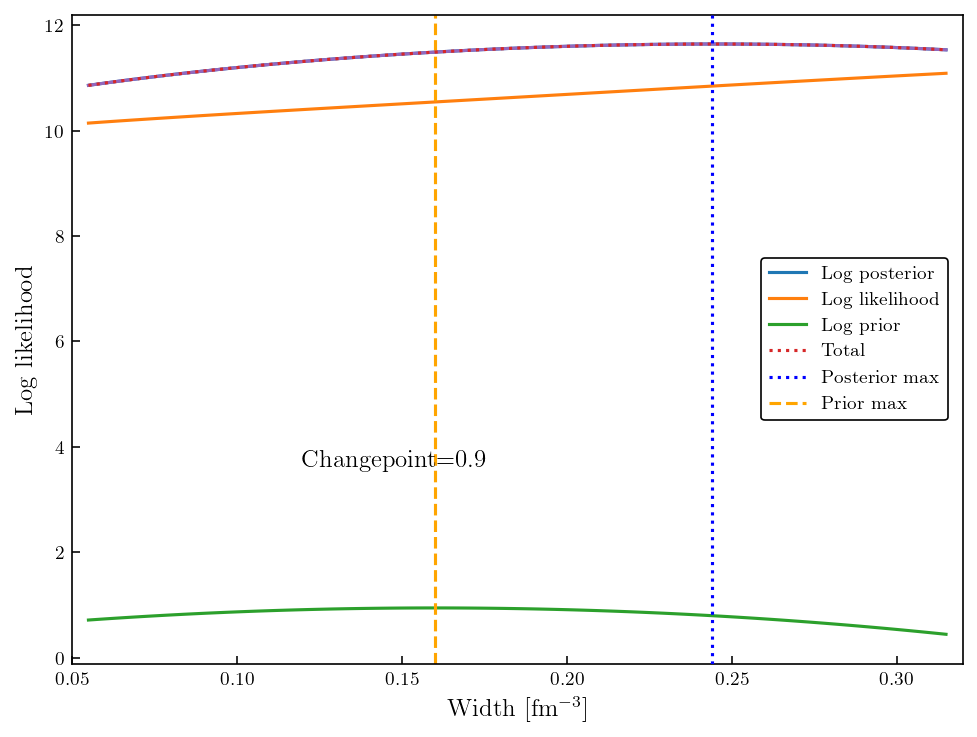

In [465]:
log_likelihood = []
if switch == 'sigmoid':
    test_w = np.linspace(0.055, 0.315, 100)
elif switch == 'tanh':
    test_w = np.linspace(0.105, 0.635, 100)
#chp = np.exp(gpcp.kernel_.theta[0])
chp = 0.9

logprior = []
loglikelihood = []
log_posterior=[]
for w in test_w:
    if switch == 'sigmoid':
        kernel = SigmoidChangepoint(ls1=chiral_ls, ls2=pqcd_ls, cbar1=chiral_cbar, cbar2=pqcd_cbar, 
                         changepoint=chp, changepoint_bounds='fixed', width=w, \
                             width_bounds=[w-0.0001, w+0.0001])
    if switch == 'tanh':
        kernel = TanhChangepoint(ls1=chiral_ls, ls2=pqcd_ls, cbar1=chiral_cbar, cbar2=pqcd_cbar, 
                         changepoint=chp, changepoint_bounds='fixed', width=w, \
                             width_bounds=[w-0.0001, w+0.0001])
    gpcptest2 = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data_2['cov']
    )
    gpcptest2.fit(X_train, y_train, priors=True, prior_choice='changepoint', \
                  prior_type=prior_dict, switch=switch, cutoff=cutoff)
    log_posterior.append(gpcptest2.log_marginal_likelihood())
    logprior.append(gpcptest2.log_prior)
    loglikelihood.append(gpcptest2.log_likelihood)
    
# assign to array
#sig_likelihood = loglikelihood
    
ind = np.where([np.asarray(log_posterior[i]) >= max(log_posterior) \
                for i in range(len(log_posterior))])[0][-1]
ind_prior = np.where([np.asarray(logprior[i]) >= max(logprior) for i in range(len(logprior))])[0][-1]

cp_final = 0.9
#cp_final = round(np.exp(gpcp.kernel_.theta[0]), 4)
w_final = round(np.exp(gpcp.kernel_.theta[0]), 4)

print('Value of width at maximum log likelihood:', test_w[ind])
print('Value from regression:', w_final)

plt.plot(test_w, log_posterior, label=r'Log posterior')
plt.plot(test_w, loglikelihood, label=r'Log likelihood')
plt.plot(test_w, logprior, label=r'Log prior')
plt.plot(test_w, np.asarray(loglikelihood)+np.asarray(logprior), label=r'Total', zorder=10, linestyle='dotted')
plt.axvline(x=test_w[ind], linestyle='dotted', label=r'Posterior max', color='blue', zorder=10)
plt.axvline(x=test_w[ind_prior], linestyle='dashed', label=r'Prior max', color='orange')

# plt.axvline(x=test_w[ind], linestyle='dashed', color='darkorange', alpha=0.3)
# plt.axvline(x=w_final, linestyle='-.', color='forestgreen', alpha=0.3)   # plot the changepoint result
plt.plot(test_w, log_posterior)
plt.xlabel(r'Width [fm$^{-3}$]', fontsize=12)
if switch == 'tanh':
    plt.xlim(0.05, 0.64)
elif switch == 'sigmoid':
    plt.xlim(0.05, 0.32)
plt.text(0., 0., 'Changepoint={}'.format(cp_final), fontsize=12, transform=ax.transAxes)
plt.ylabel('Log likelihood', fontsize=12)
plt.legend()

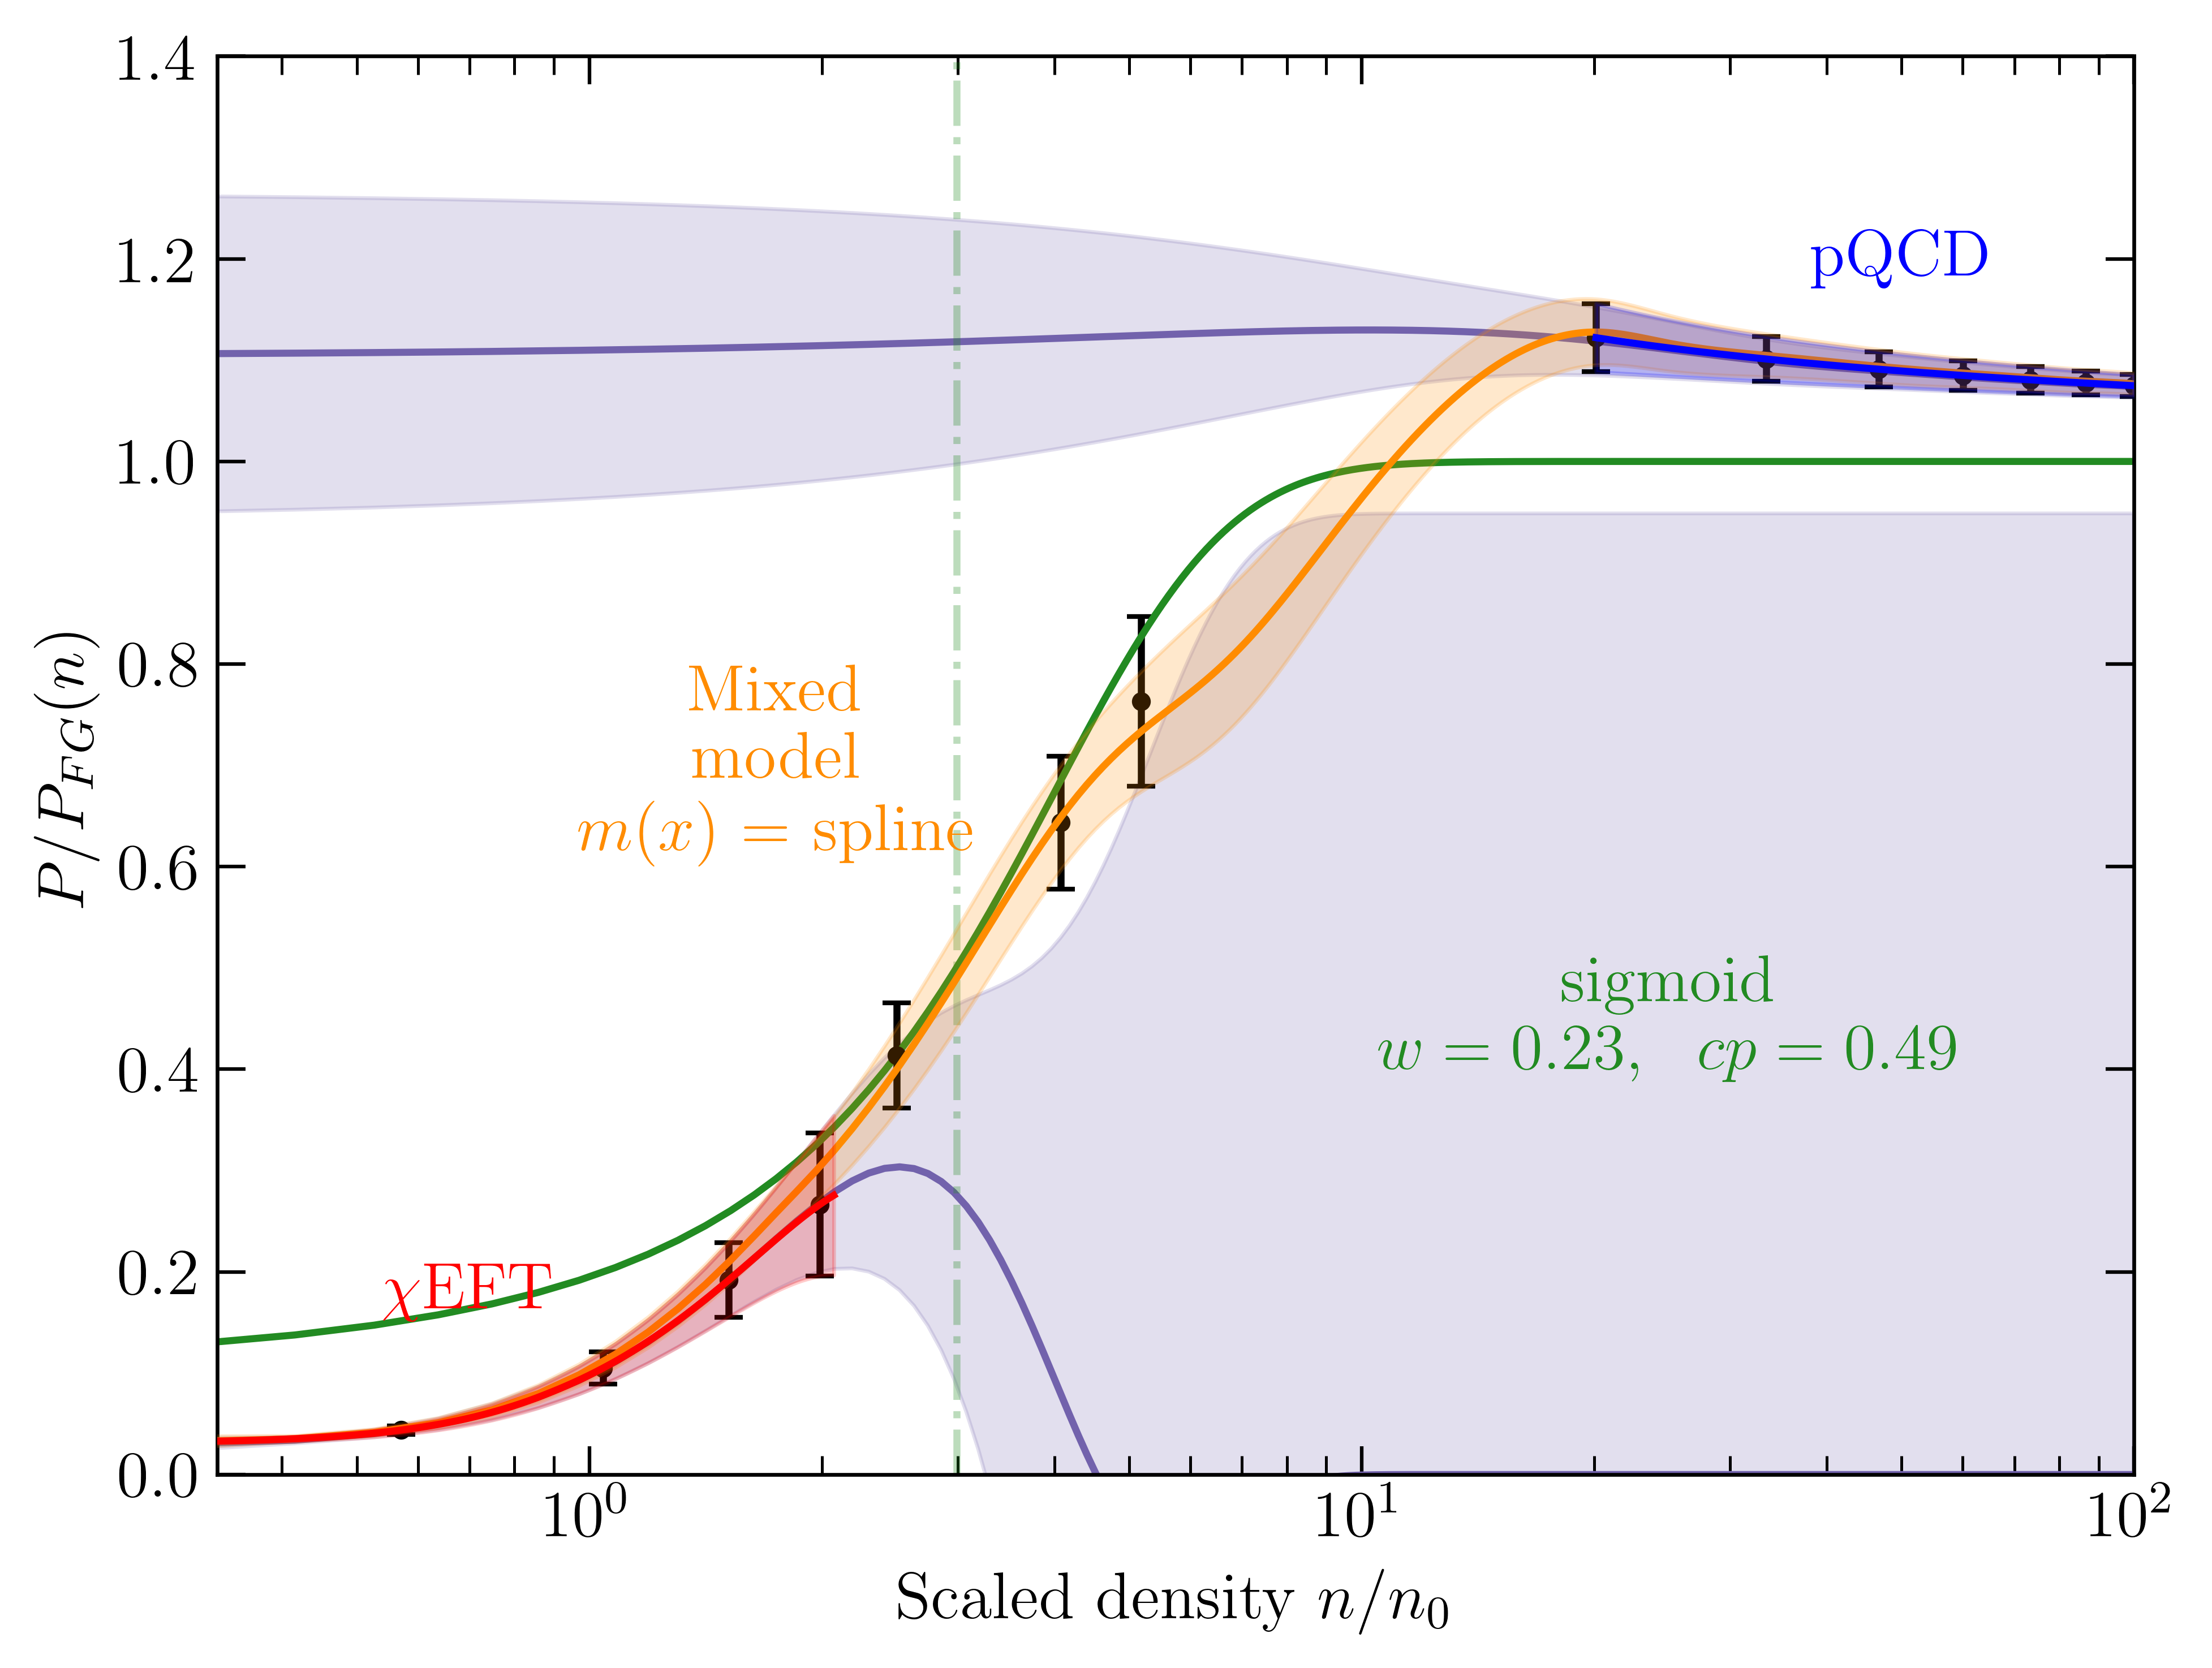

In [466]:
# try predicting with this kernel
X = density_test.reshape(-1,1)

# prediction
y_pred_0, y_stdv_0 = gpcp.predict(X, return_std=True)
_, y_cov_0 = gpcp.predict(X, return_cov=True)

if mean_function is True:
    y_pred_0_scaled = y_pred_0 + np.exp(log_full_spline(total_dens, total_data, x_select=density_test))
else: 
    y_pred_0_scaled = y_pred_0

# plot the result
fig, ax = plt.subplots(1,1, dpi=600)

# check the plotting of both of these together, see what they look like
ax.tick_params(which='major', labelsize=14, right=True, top=True, length=6)
ax.tick_params(which='minor', right=True, top=True, length=4)
ax.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N3LO)', zorder=10)
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, \
                alpha=0.2, color=color_xeft, zorder=9)
ax.plot(density_test/n0, chi_predict, color=colors[2])
ax.fill_between(density_test/n0, chi_predict-chi_std_predict, chi_predict+chi_std_predict, \
                 color=colors[2], alpha=0.2)
ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N2LO)', zorder=10)
ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd, \
                zorder=9)
ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_frg)
ax.plot(density_test/n0, pqcd_predict, color=colors[2])
ax.fill_between(density_test/n0, pqcd_predict-pqcd_std_predict, \
                 pqcd_predict+pqcd_std_predict, color=colors[2], alpha=0.2)
ax.plot(X[:,0]/n0, y_pred_0_scaled, color='darkorange', zorder=8)
ax.fill_between(X[:,0]/n0, y_pred_0_scaled-y_stdv_0, \
                 y_pred_0_scaled+y_stdv_0, alpha=0.2, color='darkorange', zorder=7)

# changepoint location
cp_final = round(np.exp(gpcp.kernel_.theta[0]), 2)
w_final = round(np.exp(gpcp.kernel_.theta[1]), 2)

# plot this
if switch == 'sigmoid':
    ax.plot(density_test/n0, (1.0 / (1.0 + np.exp(-(density_test-cp_final)/w_final))), color='forestgreen')
elif switch == 'tanh':
    ax.plot(density_test/n0, (0.5 +  0.5 * np.tanh((density_test-cp_final)/w_final)), color='forestgreen')
ax.text(25.0, 0.45, r'''{}
$w={},~~cp={}$'''.format(switch, w_final, cp_final),\
        color='forestgreen', fontsize=14, va='center', ha='center')
ax.axvline(x=cp_final/n0, linestyle='-.', color='forestgreen', alpha=0.3)   # plot the changepoint result

# some labelling for fun times
ax.text(0.7, 0.18, r'$\chi$EFT', va='center', ha='center', fontsize=14, color='red')
ax.text(50.0, 1.2, r'pQCD', va='center', ha='center', fontsize=14, color='blue')
ax.text(1.75, 0.7, r'''Mixed 
model
$m(x)$ = {}'''.format(type_mean), va='center', ha='center', \
        multialignment='center', fontsize=14, color='darkorange')

# other things
ax.set_xscale('log')
ax.set_xlabel('Scaled density $n/n_{0}$', fontsize=14)
ax.set_ylabel(r'$P/P_{FG}(n)$', fontsize=14)
ax.set_xlim(0.33, 100.0)
ax.set_ylim(0.0, 1.4)
if len(new_pts) == 3:
    fig.savefig('HIC_FRG/Plot_{}_{}_{}_{}.png'.format(cutoff, number, mean_function, switch))
# if chiral_cutoff is True:
#     fig.savefig('GIF_plots_Greedy/Mean_function/Plot_FRG_{}_{}_{}_{}.png'.format(cutoff, number, mean_function, chiral_location))
# else:
#     fig.savefig('GIF_plots_Greedy/Mean_function/Plot_FRG_{}_{}_{}.png'.format(cutoff, number, mean_function))
plt.show()

In [467]:
np.savez('../data/Paper_data/info_pres_20n0_{}_{}.npz'.format(mean_function, len(new_pts)), \
         dens=density_test, mean=y_pred_0_scaled, std=y_stdv_0, cp=cp_final, w=w_final)

In [468]:
# value of the pressure at the same point as the FRG one that is in tension
# ind_pres = np.where([density_test[i] <= frg_dens[7] for i in range(len(density_test))])[0][-1]
# print('Scaled pressure here: ', y_pred_0[ind_pres], 'and std dev: ', y_stdv_0[ind_pres])

# # calculate the number of sigma different the two calculations are
# sigma = np.abs(y_pred_0[ind_pres] - frg_mean[7]) / np.sqrt(frg_std[7]**2.0 + y_stdv_0[ind_pres]**2.0)
# print(sigma)

In [469]:
# np.savez('chiral_points_2_2n0.npz', dens=training_data_2['dens'], \
#          mean=training_data_2['mean'], std=training_data_2['std'], cov=training_data_2['cov'])

---

## Adding mock fRG data based on greedy algorithms

In [470]:
if hic_data is True:
    
    # check HIC counter
    if hic_counter == 1 and len(new_pts) != 3:
        
        print('Now adding mock data.')
                
        # find the largest error
        max_arr_envelope = max(2.0 * y_stdv_0)
        ind_max_arr = np.where([max_arr_envelope <= 2.0 * y_stdv_0[i] for i in range(len(y_stdv_0))])[0][0]
        print('Largest error location: ', density_test[ind_max_arr]/n0)

        # use this location for the next point in fRG data 
        if density_test[ind_max_arr] not in np.asarray(new_pts):
            new_pts.append(density_test[ind_max_arr])
        else:
            pass
        
        # calculate the std dev for the mock data
        uppercontourgrid = uppercontour(np.asarray(new_pts[1:])/n0)
        lowercontourgrid = lowercontour(np.asarray(new_pts[1:])/n0)
                
        # set up the mock data arrays for the loops
        mock_mean = np.zeros([len(new_pts)-1])
        mock_std = np.zeros([len(new_pts)-1])
        mock_cov = np.zeros([len(new_pts)-1, len(new_pts)-1])
        
        if larger_errors is True:
            std_last = frg_data['std'][-1]
            # use it for every value in the set
            mock_std = std_last*np.ones(len(new_pts)-1)

        for i in range(len(new_pts[1:])):
            mock_mean[i] = (lowercontourgrid[i] + uppercontourgrid[i])/2.0
            
            if larger_errors is False:
                mock_std[i] = (uppercontourgrid[i]-lowercontourgrid[i])/2.0
            mock_cov[i,i] = np.square(mock_std[i])
            
        # concatenate the HIC data to these arrays
        frg_mean = np.concatenate((hic_mean, mock_mean))
        frg_std = np.concatenate((hic_std, mock_std))
        frg_cov = block_diag(hic_cov, mock_cov)
        
        # check values here
        print('Density: ', new_pts, 'and mean: ', frg_mean, 'and cov shape: ', frg_cov.shape)
        
    # make HIC data array and add to mock data
    elif len(new_pts) == 0 and hic_counter == 0:

        # define the lists to be used like usual
        hic_mean = np.zeros([1])
        hic_std = np.zeros([1])
        hic_cov = np.zeros([1])

        # use the HIC data only ONCE
        if dens_hic not in np.asarray(new_pts):
            new_pts.append(dens_hic)
            hic_mean[0] = scaled_hic
            hic_std[0] = scaled_std_hic
            hic_cov[0] = scaled_std_hic**2.0

            # check values here
            print('Just using HIC data. Density: ', new_pts, 'and mean: ', hic_mean)
            
            # store in the frg arrays
            frg_mean = hic_mean
            frg_std = hic_std
            frg_cov = hic_cov
            
        else:
            pass
    
else:
    # this code does the whole calculation at once, not merely adding as it goes
    if len(new_pts) != 3:

        # find the largest error
        max_arr_envelope = max(2.0 * y_stdv_0)
        ind_max_arr = np.where([max_arr_envelope <= 2.0 * y_stdv_0[i] for i in range(len(y_stdv_0))])[0][0]
        print('Largest error location: ', density_test[ind_max_arr]/n0)

        # use this location for the next point in fRG data 
        if density_test[ind_max_arr] not in np.asarray(new_pts):
            new_pts.append(density_test[ind_max_arr])
        else:
            pass
        uppercontourgrid = uppercontour(np.asarray(new_pts)/n0)
        lowercontourgrid = lowercontour(np.asarray(new_pts)/n0)

        # add to the dict (rerun all generations of means, stds, not time consuming)
        frg_mean = np.zeros(len(new_pts))
        frg_std = np.zeros(len(new_pts))
        frg_cov = np.zeros([len(new_pts), len(new_pts)])

        if larger_errors is True:
            std_last = frg_data['std'][-1]
            # use it for every value in the set
            frg_std = std_last*np.ones(len(new_pts))

        for i in range(len(new_pts)):
            frg_mean[i] = (lowercontourgrid[i] + uppercontourgrid[i])/2.0
            if larger_errors is False:
                frg_std[i] = (uppercontourgrid[i]-lowercontourgrid[i])/2.0
            frg_cov[i,i] = np.square(frg_std[i])

    # check values here
    print('Density: ', new_pts, 'and mean: ', frg_mean, 'and cov shape:', frg_cov)

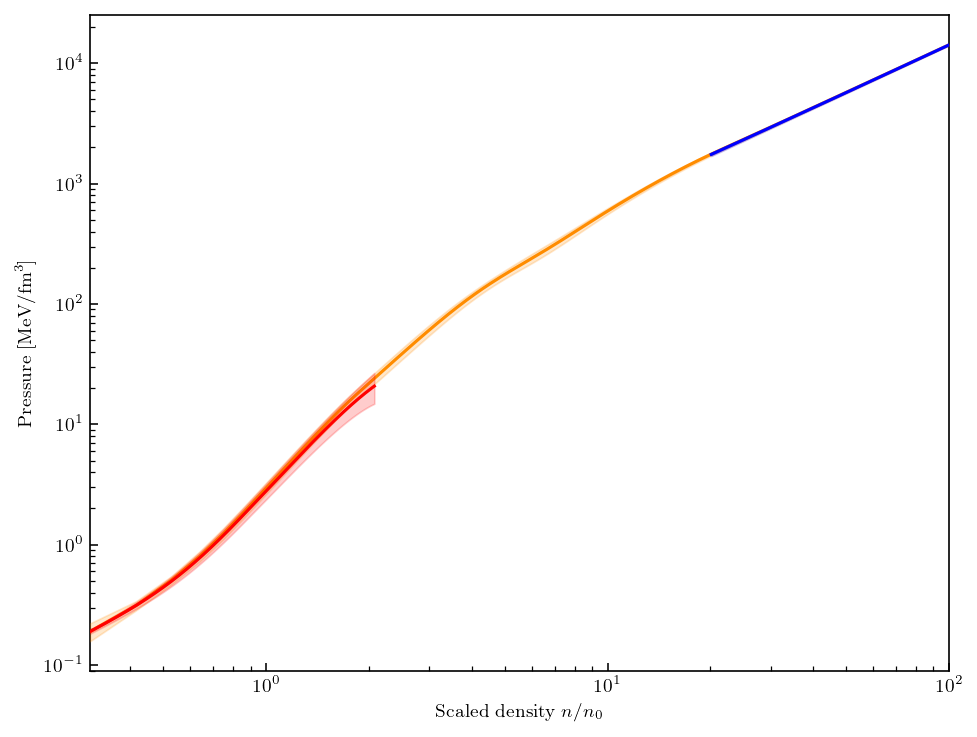

In [471]:
# do this conversion for the data
data_convert_arr = convert_interp(n_xeft)
data_pqcd_convert_arr = convert_interp(n_pqcd)

# mixed model
unscaled_data_scaled = gp_cs2_convert_arr * y_pred_0_scaled
unscaled_std = gp_cs2_convert_arr * y_stdv_0

# chiral EFT
unscaled_chi_data = data_convert_arr * p_mean_xeft
unscaled_chi_std = data_convert_arr * p_stdv_xeft

# pQCD
unscaled_pqcd_data = data_pqcd_convert_arr * p_mean_pqcd
unscaled_pqcd_std = data_pqcd_convert_arr * p_stdv_pqcd

# plot the scaled result
plt.plot(n_xeft/n0, unscaled_chi_data, color='red', label=r'ChEFT (N3LO)', zorder=20)
plt.fill_between(n_xeft/n0, unscaled_chi_data-unscaled_chi_std, unscaled_chi_data+unscaled_chi_std, \
                alpha=0.2, color=color_xeft, zorder=20)
plt.plot(n_pqcd/n0, unscaled_pqcd_data, color='blue', label=r'pQCD (N2LO)', zorder=20)
plt.fill_between(n_pqcd/n0, unscaled_pqcd_data-unscaled_pqcd_std, unscaled_pqcd_data+unscaled_pqcd_std, \
                 alpha=0.2, color=color_pqcd, zorder=20)
plt.plot(X[:,0]/n0, unscaled_data_scaled, color='darkorange')
plt.fill_between(X[:,0]/n0, unscaled_data_scaled-unscaled_std, \
                 unscaled_data_scaled+unscaled_std, alpha=0.2, color='darkorange', zorder=10)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Scaled density $n/n_{0}$')
plt.ylabel(r'Pressure [MeV/fm$^{3}$]')
plt.xlim(min(density_test)/n0, 100.0)
plt.show()

---
---

## Comparison plots

In [472]:
# save mean function data to use with the zero mean function for comparison plot below!!!
# pressure_mean_function_0 = {
#     'dens': density_test,
#     'mean': y_pred_0_scaled,
#     'std': y_stdv_0,
#     'cp': cp_final,
#     'w': w_final
# }

# frg_mean_0_data = {
#     'dens': new_pts,
#     'mean': frg_mean,
#     'std': frg_std
# }

In [473]:
# # plot the comparisons
# fig, ax = plt.subplots(1,1, dpi=600)

# # check the plotting of both of these together, see what they look like
# ax.tick_params(which='major', labelsize=14, right=True, top=True, length=6)
# ax.tick_params(which='minor', right=True, top=True, length=4)
# ax.plot(n_xeft/n0, p_mean_xeft, color='red', zorder=10)
# ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, \
#                 alpha=0.2, color=color_xeft, zorder=9)
# # ax.plot(density_test/n0, chi_predict, color=colors[2])
# # ax.fill_between(density_test/n0, chi_predict-chi_std_predict, chi_predict+chi_std_predict, \
# #                  color=colors[2], alpha=0.2)
# ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', zorder=10)
# ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd, \
#                 zorder=9)
# ax.errorbar(x=np.asarray(frg_mean_0_data['dens'])/n0, y=frg_mean_0_data['mean'], yerr=frg_mean_0_data['std'], \
#             **errorbar_kwargs_2, label=r'$m(x) = spline$')
# # ax.plot(density_test/n0, pqcd_predict, color=colors[2])
# # ax.fill_between(density_test/n0, pqcd_predict-pqcd_std_predict, \
# #                  pqcd_predict+pqcd_std_predict, color=colors[2], alpha=0.2)
# ax.plot(X[:,0]/n0, y_pred_0_scaled, color='forestgreen', zorder=8)
# ax.fill_between(X[:,0]/n0, y_pred_0_scaled-y_stdv_0, \
#                  y_pred_0_scaled+y_stdv_0, alpha=0.2, color='forestgreen', zorder=7)
# ax.plot(X[:,0]/n0, pressure_mean_function_0['mean'], color='darkorange', zorder=6)
# ax.fill_between(X[:,0]/n0, pressure_mean_function_0['mean']-pressure_mean_function_0['std'], \
#                  pressure_mean_function_0['mean']+pressure_mean_function_0['std'], alpha=0.2, \
#                 color='darkorange', zorder=5)

# # FRG data sets
# ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
#             **errorbar_kwargs_frg, label=r'$m(x) = 0$')

# # some labelling for fun times
# ax.text(0.7, 0.18, r'$\chi$EFT', va='center', ha='center', fontsize=14, color='red')
# ax.text(50.0, 1.2, r'pQCD', va='center', ha='center', fontsize=14, color='blue')
# ax.text(1.5, 0.7, r'''Mixed model
# $m(n_B) = 0$
# $cp = {}$
# $w = {}$'''.format(pressure_mean_function_0['cp'], pressure_mean_function_0['w']), \
#         va='center', ha='center', multialignment='center', fontsize=14, color='darkorange')
# ax.text(20.0, 0.6, r'''Mixed model
# $m(n_B)$ = spline
# $cp = {}$
# $w = {}$'''.format(cp_final, w_final), va='center', ha='center', \
#         multialignment='center', fontsize=14, color='forestgreen')

# # plot changepoints for visual aid
# ax.axvline(x=pressure_mean_function_0['cp']/n0, linestyle='-.', color='darkorange', alpha=0.2, zorder=0)
# ax.axvline(x=cp_final/n0, linestyle='-.', color='forestgreen', alpha=0.2, zorder=0)

# # plot sigmoids
# ax.plot(density_test/n0, \
#         (1.0 / (1.0 + np.exp(-(density_test-pressure_mean_function_0['cp'])/pressure_mean_function_0['w']))),\
#         color='darkorange', linestyle='dotted', alpha=0.3)
# ax.plot(density_test/n0, (1.0 / (1.0 + np.exp(-(density_test-cp_final)/w_final))), color='forestgreen', \
#        linestyle='dotted', alpha=0.3)

# # other things
# ax.set_xscale('log')
# ax.set_xlabel('Scaled density $n/n_{0}$', fontsize=14)
# ax.set_ylabel(r'$P/P_{FG}(n)$', fontsize=14)
# ax.set_xlim(0.33, 100.0)
# ax.set_ylim(0.0, 1.4)
# if chiral_cutoff is False:
#     fig.savefig('NSM_Plots/Comparisons/FRG_comparison_{}n0_zero_spline.png'.format(cutoff))
# else:
#     fig.savefig('NSM_Plots/Comparisons/FRG_comparison_{}n0_zero_spline_{}.png'.format(cutoff, chiral_location))
# plt.show()

---
---

## Speed of sound calculation, $c_{s}^{2}(n)$

Let's now move on to our speed of sound calculation, to obtain the energy density and speed of sound squared, and hence have inputs for our TOV solver.

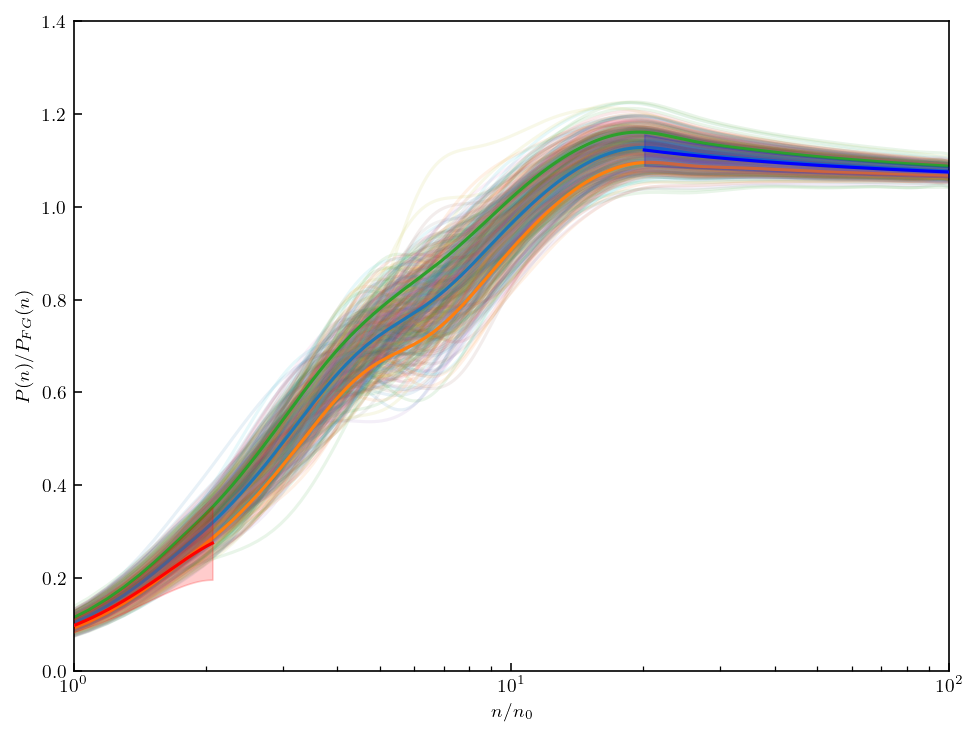

In [474]:
# sample from the pressure GP curve first
samples = 500
samples_data_gp = gpcp.sample_y(X=density_test.reshape(-1,1), n_samples=samples)

if mean_function is True:
    mean_sample = np.zeros([len(density_test), samples])
    for i in range(samples):
        mean_sample[:,i] = np.exp(log_full_spline(total_dens, total_data, x_select=density_test))
    samples_data = samples_data_gp + mean_sample
else:
    samples_data = samples_data_gp

# plot the samples to test the validity of the call
plt.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N3LO)', zorder=10)
plt.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, \
                alpha=0.2, color=color_xeft, zorder=9)
plt.plot(density_test/n0, samples_data, alpha=0.1)
plt.plot(density_test/n0, y_pred_0_scaled)
plt.plot(density_test/n0, y_pred_0_scaled-y_stdv_0)
plt.plot(density_test/n0, y_pred_0_scaled+y_stdv_0)
plt.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N2LO)', zorder=10)
plt.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd, \
                zorder=9)
plt.xlim(1.0, 100.0)
plt.ylim(0.0, 1.4)
plt.xscale('log')
plt.ylabel(r'$P(n)/P_{FG}(n)$')
plt.xlabel(r'$n/n_{0}$')
plt.show()

In [475]:
from eos_utils import cs2_routine, speed_of_sound

# testing the function
gp_dict_full = {
    'dens': density_test,
    'mean': y_pred_0_scaled,
    'std_dev': y_stdv_0,
    'samples': samples_data,
    'true': None
}

pres_dict, edens_full, cs2_sampled = cs2_routine(gp_dict_full, sat_cut=0, plot=False)

Sampling? True
Woo it is over!


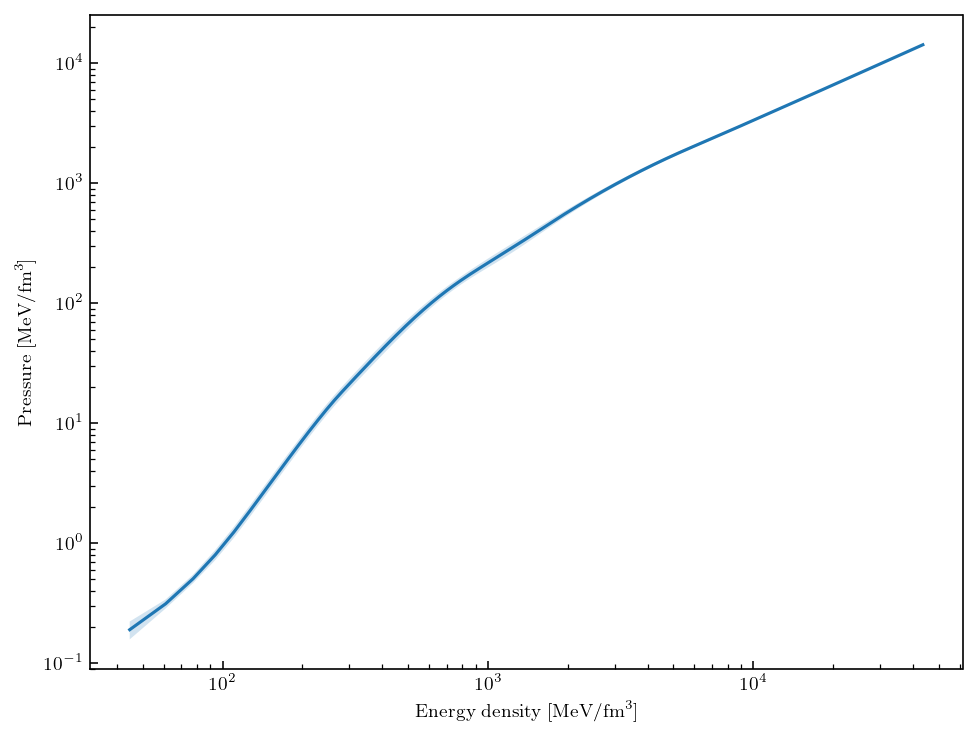

In [476]:
# plot the pressure vs. energy density for a quick check
plt.plot(edens_full['mean'], pres_dict['mean'])
plt.fill_between(edens_full['mean'], pres_dict['mean']-pres_dict['std_dev'], \
                 pres_dict['mean']+pres_dict['std_dev'], alpha=0.2)
plt.xlabel(r'Energy density [MeV/fm$^3$]')
plt.ylabel(r'Pressure [MeV/fm$^3$]')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [477]:
# reduce to causal and stable stars
from tov_utils import causality_stability

cs2_reduced, edens_reduced, pres_reduced = causality_stability(cs2_sampled['samples'].T, \
                                                     edens_full['samples'].T, pres_dict['samples'])

# get the mean and std from the reduced cs2 samples
cs2_mean_reduced = np.nanmean(cs2_reduced, axis=1)
cs2_std_reduced = np.nanstd(cs2_reduced, axis=1)

# construct needed dict of reduced pressures
presdict = {
    'dens': density_test,
    'samples': pres_reduced
}

---

## $c_{s}^{2}(n)$ plots

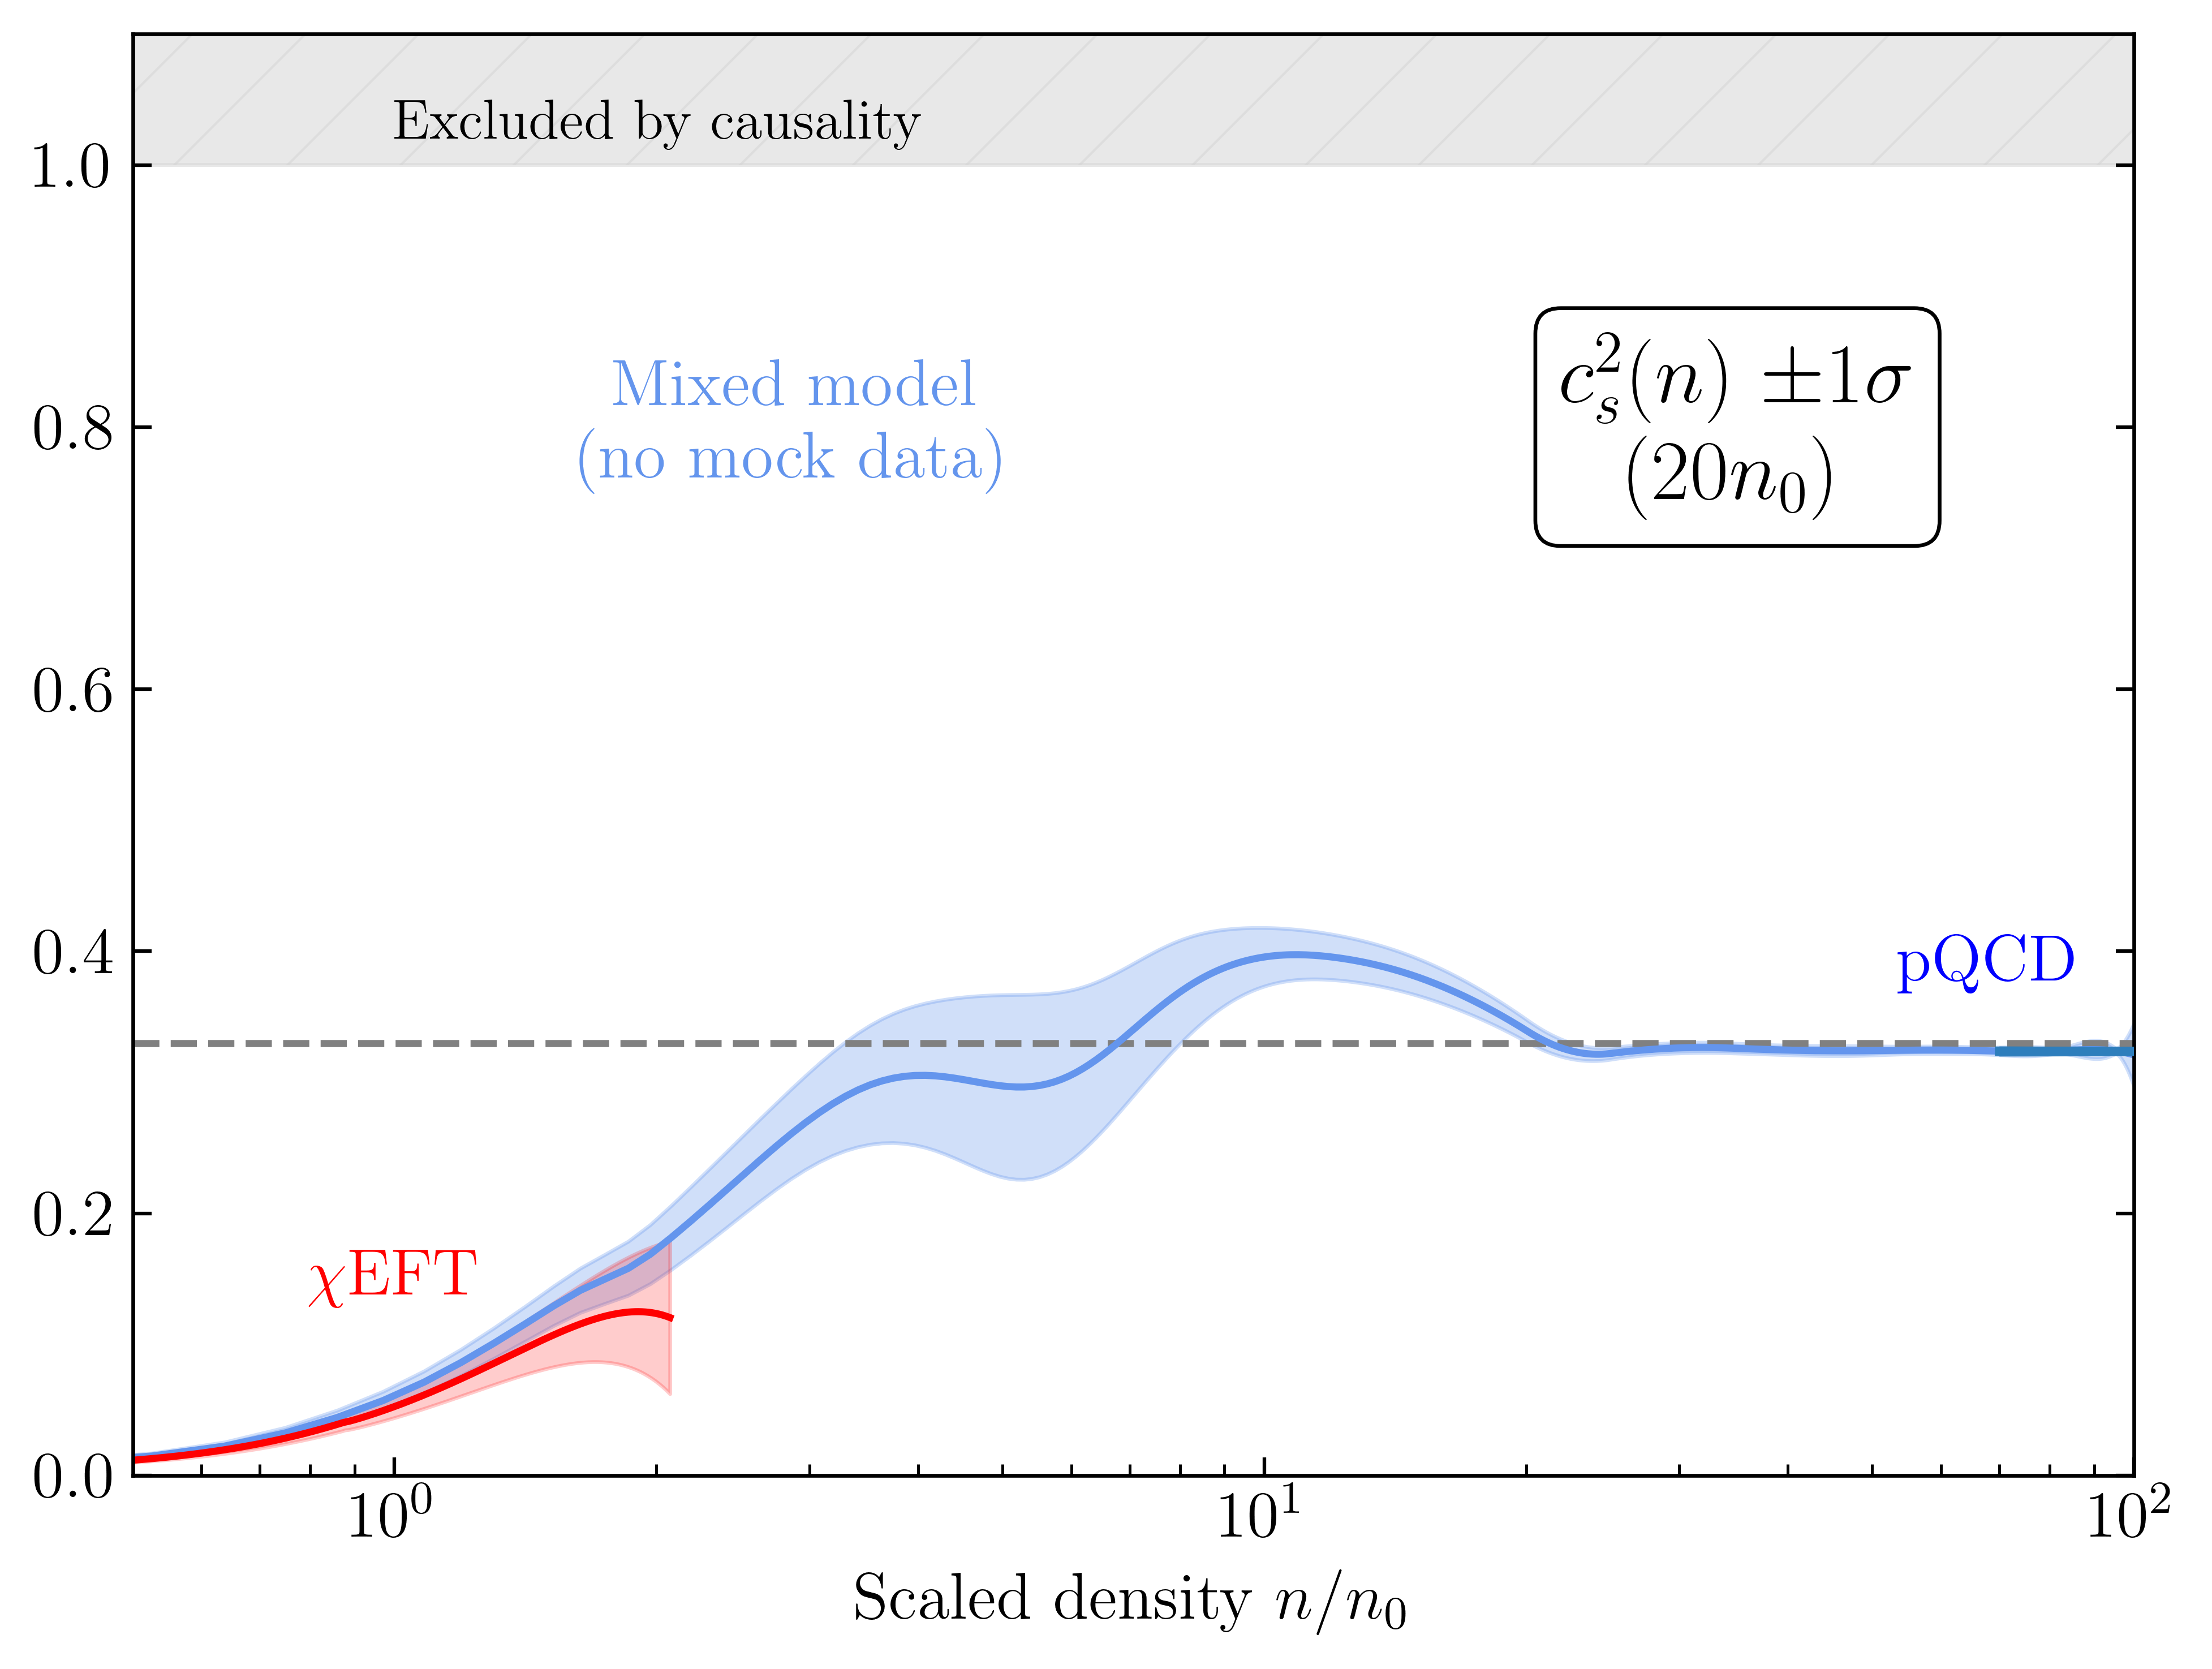

In [478]:
# plot the cs2 information
plt.figure(dpi=600)
plt.tick_params(axis='both', which='major', labelsize=14, right=True)
plt.tick_params(axis='both', which='minor', labelsize=14, right=True)

cs2_chiral = np.load('../data/NSM_data/cs2_chiral_NSM.npz')
cs2_pqcd = np.load('../data/eos_data/pqcd_cs2_NSM.npz')

# line for asymptotic limit
plt.axhline(y=0.33, linestyle='dashed', color='gray')

plt.plot(density_test/n0, cs2_sampled['mean'], color='cornflowerblue', zorder=2)
plt.fill_between(density_test/n0, cs2_sampled['mean']-cs2_sampled['std'], \
                 cs2_sampled['mean']+cs2_sampled['std'], color='cornflowerblue', alpha=0.3, zorder=1)

# chiral eft and pqcd data
plt.plot(cs2_pqcd['density']/n0, cs2_pqcd['mean'], color=colors[1], zorder=3, linewidth=2)
plt.fill_between(cs2_pqcd['density']/n0, cs2_pqcd['lower'], cs2_pqcd['upper'], \
                 zorder=2, facecolor=light_colors[1], edgecolor=colors[1], alpha=0.7)

plt.plot(cs2_chiral['density']/n0, cs2_chiral['mean'], color='red')
plt.fill_between(cs2_chiral['density']/n0, cs2_chiral['mean']-cs2_chiral['std'], \
                 cs2_chiral['mean']+cs2_chiral['std'], alpha=0.2, \
                color='red')

# exclude by causality
plt.fill_between(density_test/n0, 1.0*np.ones(len(density_test)), 1.1*np.ones(len(density_test)), \
                 color='lightgray', hatch='/', alpha=0.5)
plt.text(1.0, 1.02, r'Excluded by causality', fontsize=12)

plt.text(35.0, 0.8, r'''$c_s^2(n)$ $\pm 1\sigma$
(${}n_0$)'''.format(cutoff), va='center', ha='center', \
         fontsize=18, bbox=dict(facecolor='w', boxstyle='round'))
plt.text(68.0, 0.39, r'''pQCD''', va='center', ha='center', fontsize=14, color='blue')
plt.text(1.0, 0.15, r'''$\chi$EFT''', va='center', ha='center', fontsize=14, color='red')
plt.text(2.9, 0.8, r'''Mixed model 
(no mock data)''', va='center', ha='center', fontsize=14, color='cornflowerblue')
plt.xlim(0.5, 100.0)
plt.ylim(0.0, 1.1)
plt.xlabel(r'Scaled density $n/n_{0}$', fontsize=14)
plt.xscale('log')
plt.show()

In [479]:
# save all the envelope data for the plots in a file
np.savez('pres_cs2_3_spline_20n0.npz', dens=density_test, \
         pres_mean=y_pred_0_scaled, pres_std=y_stdv_0, cs2_mean=cs2_sampled['mean'], \
         cs2_std=cs2_sampled['std'])

if len(new_pts) == 3:
    np.savez('points_pres_spline_20n0.npz', dens=training_data_2['dens'], \
         mean=training_data_2['mean'], std=training_data_2['std'])

---
---

## Running the TOV calculations: envelopes

In [888]:
# use the data directly from the above run
from tov_utils import tov_data
import sys
sys.path.append('../../../TOV_solver')
from TOV_class import TOVsolver

In [889]:
# testing the function
gp_dict_tov = {
    'dens': density_test,
    'mean': y_pred_0_scaled,
    'std_dev': y_stdv_0,
    'samples': None,
    'true': None
}

pres_dict_tov, edens_full_tov, _ = cs2_routine(gp_dict_tov, sat_cut=0, plot=False)

# for the envelope calculation, collect as "samples" for TOV solver
tov_samples = {
    'dens': density_test,
    'samples': np.column_stack((pres_dict_tov['mean']-pres_dict_tov['std_dev'], \
                                pres_dict_tov['mean'], \
                                pres_dict_tov['mean']+pres_dict_tov['std_dev']))
}

tov_edens = np.column_stack((edens_full_tov['lower'], edens_full_tov['mean'], edens_full_tov['upper']))

tov_dict = tov_data(tov_edens, tov_samples, save=True, filepath='mock_test_data.npz')

Sampling? False
Woo it is over!
I'm done!


In [890]:
# save for M-R comparison plot
# np.savez('pres_edens_3_spline_20n0.npz', dens=density_test, pres_mean=y_pred_0_scaled, \
#          pres_std=y_stdv_0, edens_mean=edens_full_tov['mean'], \
# edens_std=edens_full_tov['upper']-edens_full_tov['mean'])

In [891]:
# spline mean
tov1 = TOVsolver(eos_filepath='mock_test_data.npz')
# tov2 = TOVsolver(eos_filepath='mock_test_data_hic.npz')
# tov3 = TOVsolver(eos_filepath='mock_test_data_hic_plus_1.npz')
# tov4 = TOVsolver(eos_filepath='mock_test_data_hic_plus_2.npz')

# no mean
#tov11 = TOVsolver(eos_filepath='mock_test_data_nomean.npz')
# tov22 = TOVsolver(eos_filepath='mock_test_data_hic_nomean.npz')
# tov33 = TOVsolver(eos_filepath='mock_test_data_hic_plus_1_nomean.npz')
# tov44 = TOVsolver(eos_filepath='mock_test_data_hic_plus_2_nomean.npz')

Woo it worked!


In [892]:
# spline mean
rad, prescent, mass = tov1.tov_routine()
# radhic, _, masshic = tov2.tov_routine()
# radhic1, _, masshic1 = tov3.tov_routine()
# radhic2, _, masshic2 = tov4.tov_routine()

# no mean
# radno, prescentno, massno = tov11.tov_routine()
# radhicno, _, masshicno = tov22.tov_routine()
# radhic1no, _, masshic1no = tov33.tov_routine()
# radhic2no, _, masshic2no = tov44.tov_routine()

Radius:  10.39450082 Maximum mass:  1.62033142288344 Central pressure:  292.9420362292324
Radius:  11.5738283144 Maximum mass:  2.011855997065183 Central pressure:  342.0973067434033
Radius:  13.1149949264 Maximum mass:  2.461877925177933 Central pressure:  342.0973067434033


In [893]:
# load NICER data
miller = np.loadtxt('../data/NICER_data/NICER+XMM_J0740_RM.txt')
miller_0030_2 = np.loadtxt('../data/NICER_data/J0030_2spot_RM.txt')
miller_0030_3 = np.loadtxt('../data/NICER_data/J0030_3spot_RM.txt')

# load NICER J0437 data
j0437 = np.loadtxt('../data/NICER_data/J0437_data/samples/J0437_3C50_BKG_AGN_hiMN_lowXPSI_wmrsamples.dat')

# load in the LIGO data from the folder
df_insens = pd.read_csv('../data/LIGO_data/EoS-insensitive_posterior_samples.dat', sep='\s+')
df_maxmass = pd.read_csv('../data/LIGO_data/Parametrized-EoS_maxmass_posterior_samples.dat', sep='\s+')

# convert to a dict
LIGO_insens = df_insens.to_dict('list')
LIGO_maxmass = df_maxmass.to_dict('list')

# LIGO data
x11 = np.asarray(LIGO_maxmass['Radius1_km'])
y11 = np.asarray(LIGO_maxmass['m1_source_frame_Msun'])
x22 = np.asarray(LIGO_maxmass['Radius2_km'])
y22 = np.asarray(LIGO_maxmass['m2_source_frame_Msun'])

## Results with spline mean function

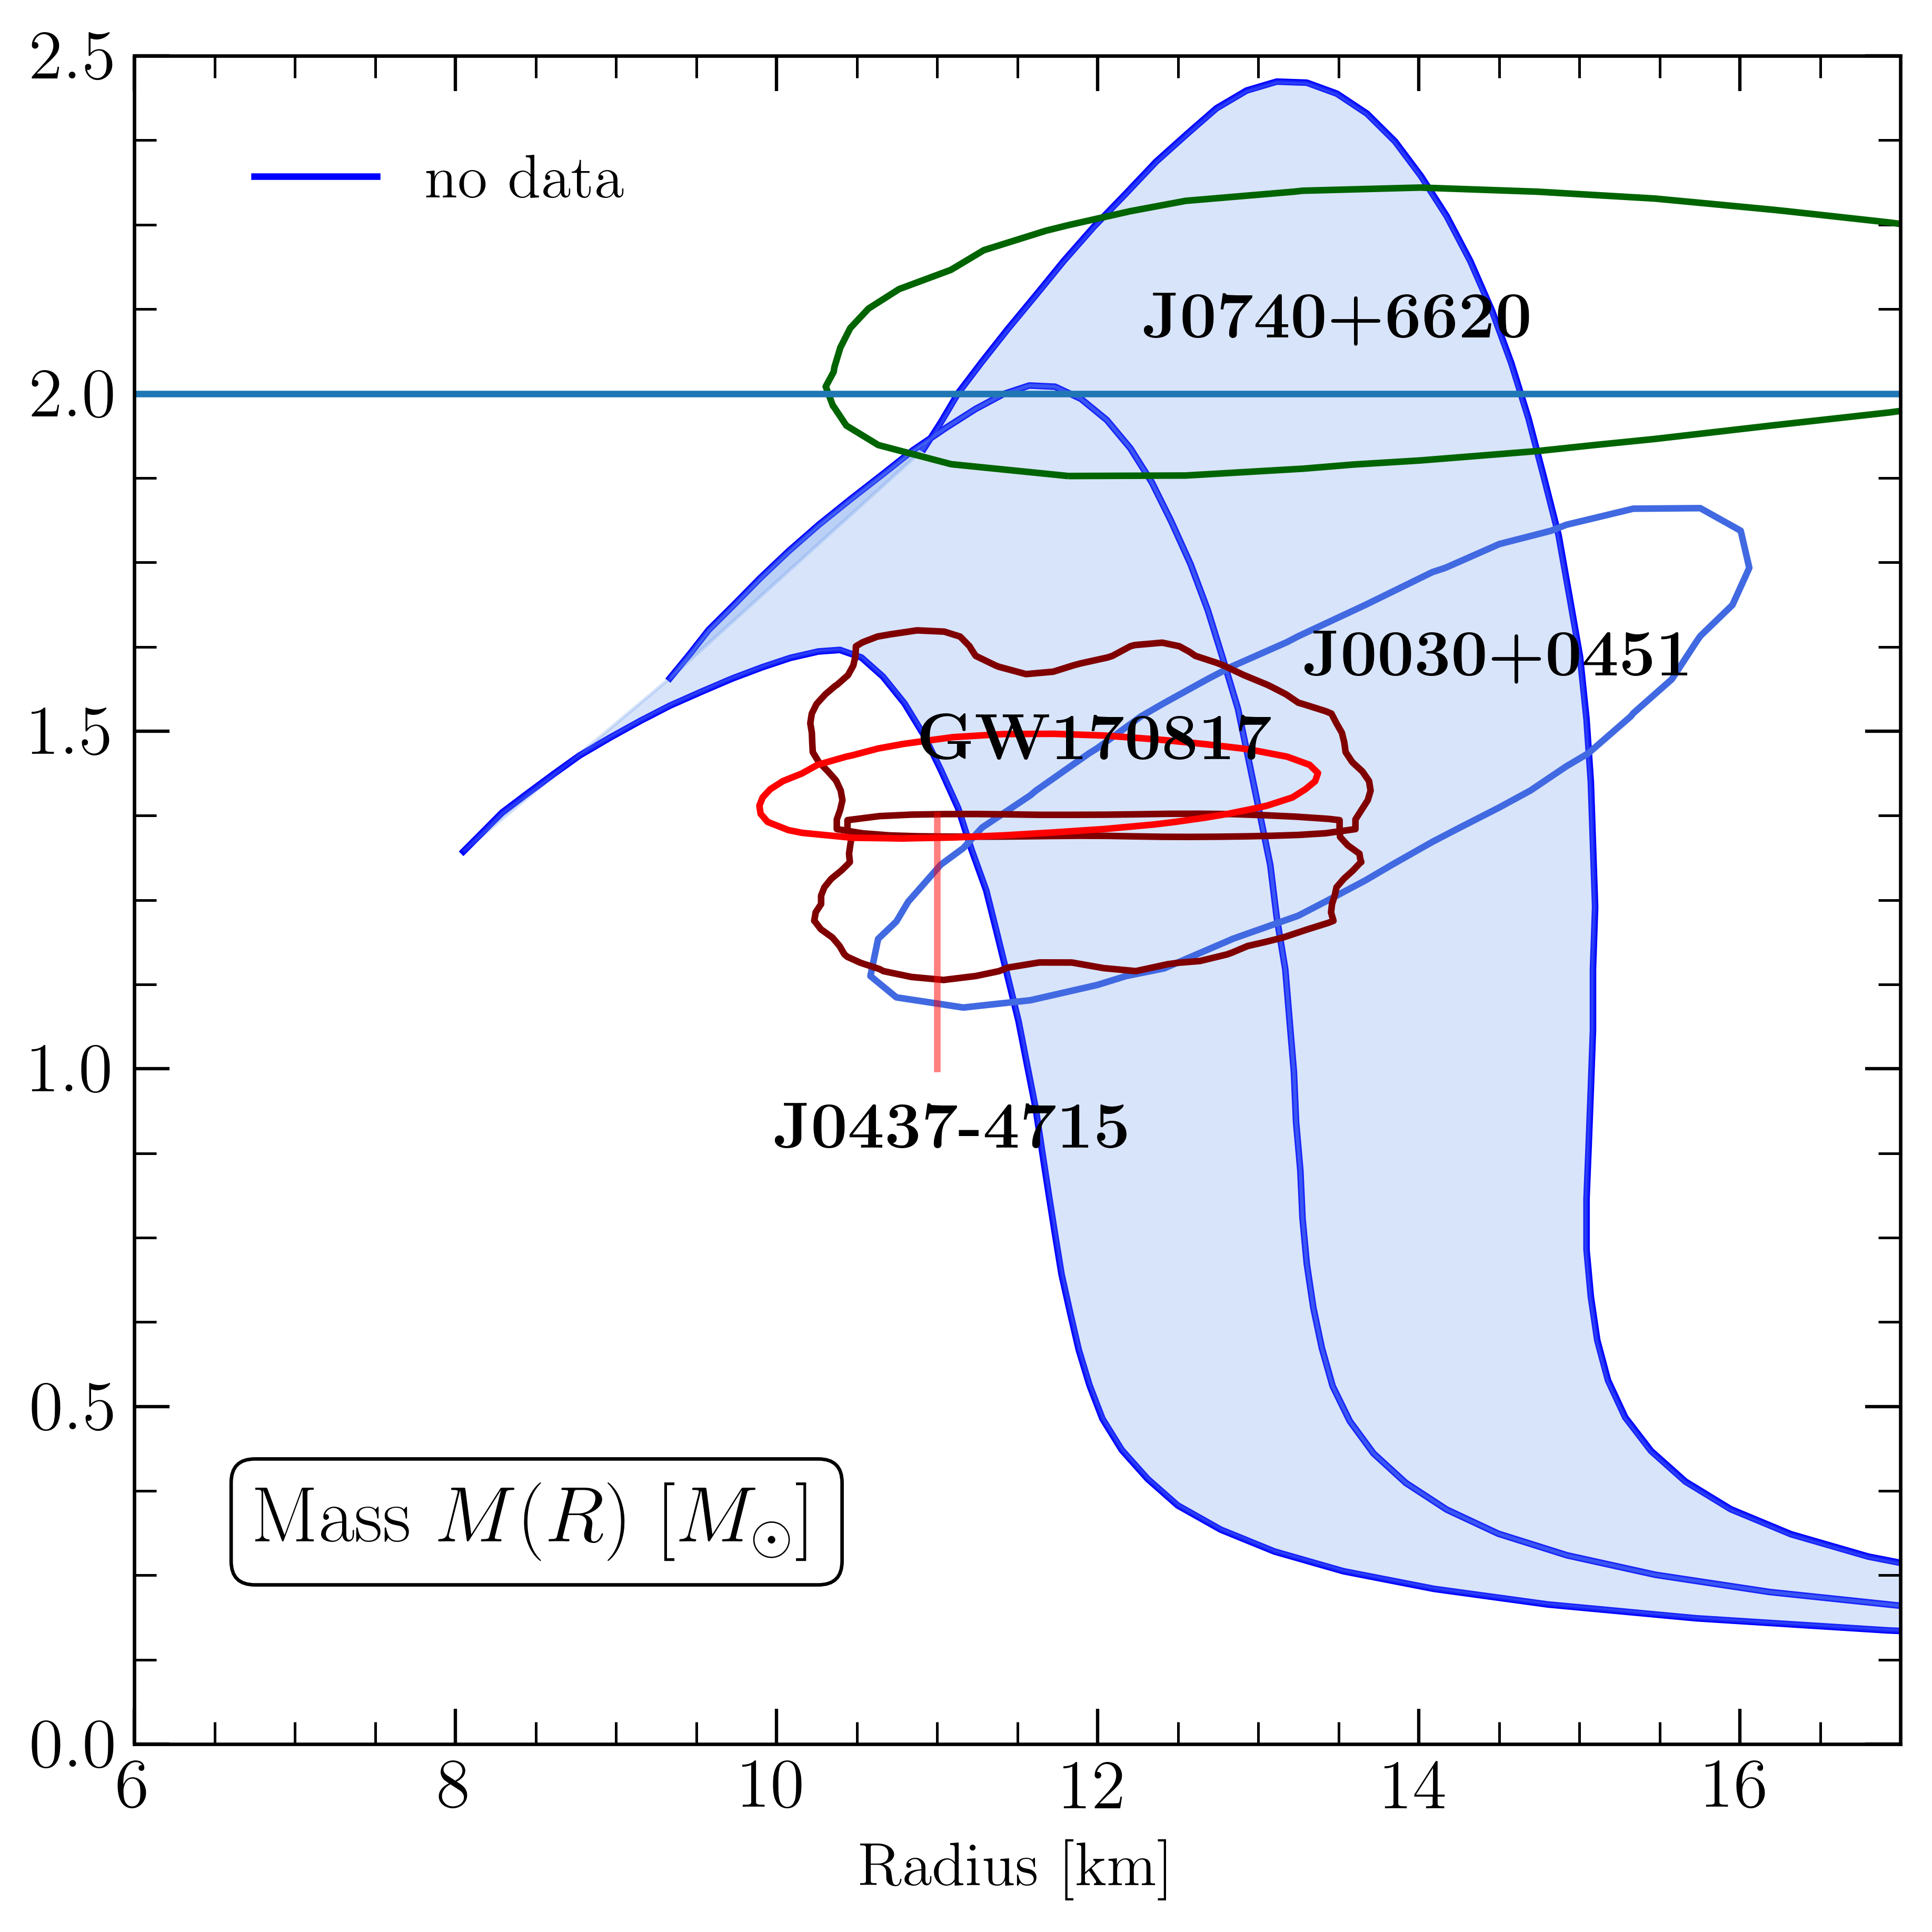

In [894]:
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon
import corner

royalpurple = '#9B30FF'

# plot the results including the samples and the overall mean, std_dev
fig = plt.figure(figsize=(6,6), dpi=600)
ax = plt.axes()

# means
ax.plot(rad, mass, color='blue', zorder=-5, label=r'no data')
# ax.plot(radhic, masshic, color='darkorange', zorder=-4, label=r'HIC')
# ax.plot(radhic1, masshic1, color='forestgreen', zorder=-3, label=r'HIC + 1')
# ax.plot(radhic2, masshic2, color=royalpurple, zorder=-2, label=r'HIC + 2')

# spline no data 
vertices = [(x, y1_val) for x, y1_val in zip(rad[:,1], mass[:,1])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(rad[:,2]), reversed(mass[:,2]))]
vertices2 = [(x, y1_val) for x, y1_val in zip(rad[:,0], mass[:,0])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(rad[:,1]), reversed(mass[:,1]))]

# hic point
# verticeshic = [(x, y1_val) for x, y1_val in zip(radhic[:,1], masshic[:,1])] + \
#            [(x, y2_val) for x, y2_val in zip(reversed(radhic[:,2]), reversed(masshic[:,2]))]
# vertices2hic = [(x, y1_val) for x, y1_val in zip(radhic[:,0], masshic[:,0])] + \
#            [(x, y2_val) for x, y2_val in zip(reversed(radhic[:,1]), reversed(masshic[:,1]))]

# # hic point + 1
# verticeshic1 = [(x, y1_val) for x, y1_val in zip(radhic1[:,1], masshic1[:,1])] + \
#            [(x, y2_val) for x, y2_val in zip(reversed(radhic1[:,2]), reversed(masshic1[:,2]))]
# vertices2hic1 = [(x, y1_val) for x, y1_val in zip(radhic1[:,0], masshic1[:,0])] + \
#            [(x, y2_val) for x, y2_val in zip(reversed(radhic1[:,1]), reversed(masshic1[:,1]))]

# # hic point + 2
# verticeshic2 = [(x, y1_val) for x, y1_val in zip(radhic2[:,1], masshic2[:,1])] + \
#            [(x, y2_val) for x, y2_val in zip(reversed(radhic2[:,2]), reversed(masshic2[:,2]))]
# vertices2hic2 = [(x, y1_val) for x, y1_val in zip(radhic2[:,0], masshic2[:,0])] + \
#            [(x, y2_val) for x, y2_val in zip(reversed(radhic2[:,1]), reversed(masshic2[:,1]))]

polygon = Polygon(vertices, closed=True, color="cornflowerblue", alpha=0.25)
polygon2 = Polygon(vertices2, closed=True, color="cornflowerblue", alpha=0.25)
plt.gca().add_patch(polygon)
plt.gca().add_patch(polygon2)

# polygonhic = Polygon(verticeshic, closed=True, color="darkorange", alpha=0.25)
# polygon2hic = Polygon(vertices2hic, closed=True, color="darkorange", alpha=0.25)
# plt.gca().add_patch(polygonhic)
# plt.gca().add_patch(polygon2hic)

# polygonhic1 = Polygon(verticeshic1, closed=True, color='forestgreen', alpha=0.25)
# polygon2hic1 = Polygon(vertices2hic1, closed=True, color='forestgreen', alpha=0.25)
# plt.gca().add_patch(polygonhic1)
# plt.gca().add_patch(polygon2hic1)

# polygonhic2 = Polygon(verticeshic2, closed=True, color=mediumpurple, alpha=0.25)
# polygon2hic2 = Polygon(vertices2hic2, closed=True, color=mediumpurple, alpha=0.25)
# plt.gca().add_patch(polygonhic2)
# plt.gca().add_patch(polygon2hic2)

handles, labels = plt.gca().get_legend_handles_labels()

# NICER and LIGO contours
corner.hist2d(miller[:,0], miller[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.8, ax=ax, color='darkgreen', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=False)
corner.hist2d(miller_0030_2[:,0], miller_0030_2[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.8, ax=ax, color='royalblue', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=False)
corner.hist2d(x11, y11, bins=30, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=1.1, ax=ax, color='maroon', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=False)
corner.hist2d(x22, y22, bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.9, ax=ax, color='maroon', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=False)
corner.hist2d(j0437[:,2], j0437[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=j0437[:,0], \
              levels=[0.9], smooth=0.8, ax=ax, color='red', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=False)
    
# labels for LIGO and NICER data
ax.text(13.5, 2.15, r'$\textbf{J0740+6620}$', zorder=100, ha='center', va='top', fontsize=15)
ax.text(14.5, 1.65, r'$\textbf{J0030+0451}$', zorder=100, ha='center', va='top', fontsize=15)

# remove duplicates by converting to a dictionary
unique = dict(zip(labels, handles))
legend = ax.legend(unique.values(), unique.keys(), fontsize=14, frameon=False, bbox_to_anchor=[0.32, 0.985])

# GW 190814
ax.text(12.0, 1.525, r'$\textbf{GW170817}$', ha='center', va='top', fontsize=15, zorder=10)
ax.axvline(x=11.0, ymin=0.4, ymax=0.55, color='red', alpha=0.5)
ax.text(11.1, 0.95, r'$\textbf{J0437-4715}$', ha='center', va='top', fontsize=15)

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.125))
ax.tick_params(axis='both', which='major', labelsize=16, right=True, top=True, length=8)
ax.tick_params(axis='both', which='minor', labelsize=16, right=True, top=True, length=5)
ax.set_xlim(6.0, 17.0)
ax.set_ylim(0.0,2.5)
ax.set_xlabel(r'Radius [km]', fontsize=14)
ax.text(6.75, 0.30, r'Mass $M(R)$ $[M_\odot]$', fontsize=18, bbox=dict(facecolor='w', boxstyle='round'))
ax.axhline(y=2.0)
#fig.savefig('../figures/ANM_Figures/comparison_MR_spline_sigmoid_HIC_FRG_3.pdf')
plt.show()

In [770]:
print(training_data_2['mean'][4:7]*convert_interp(training_data_2['dens'][4:7]))
print(training_data_2['dens'][4:7])

[ 40.         265.86199469 392.34697572]
[0.41       0.86840934 1.06846496]


## Results with no mean function

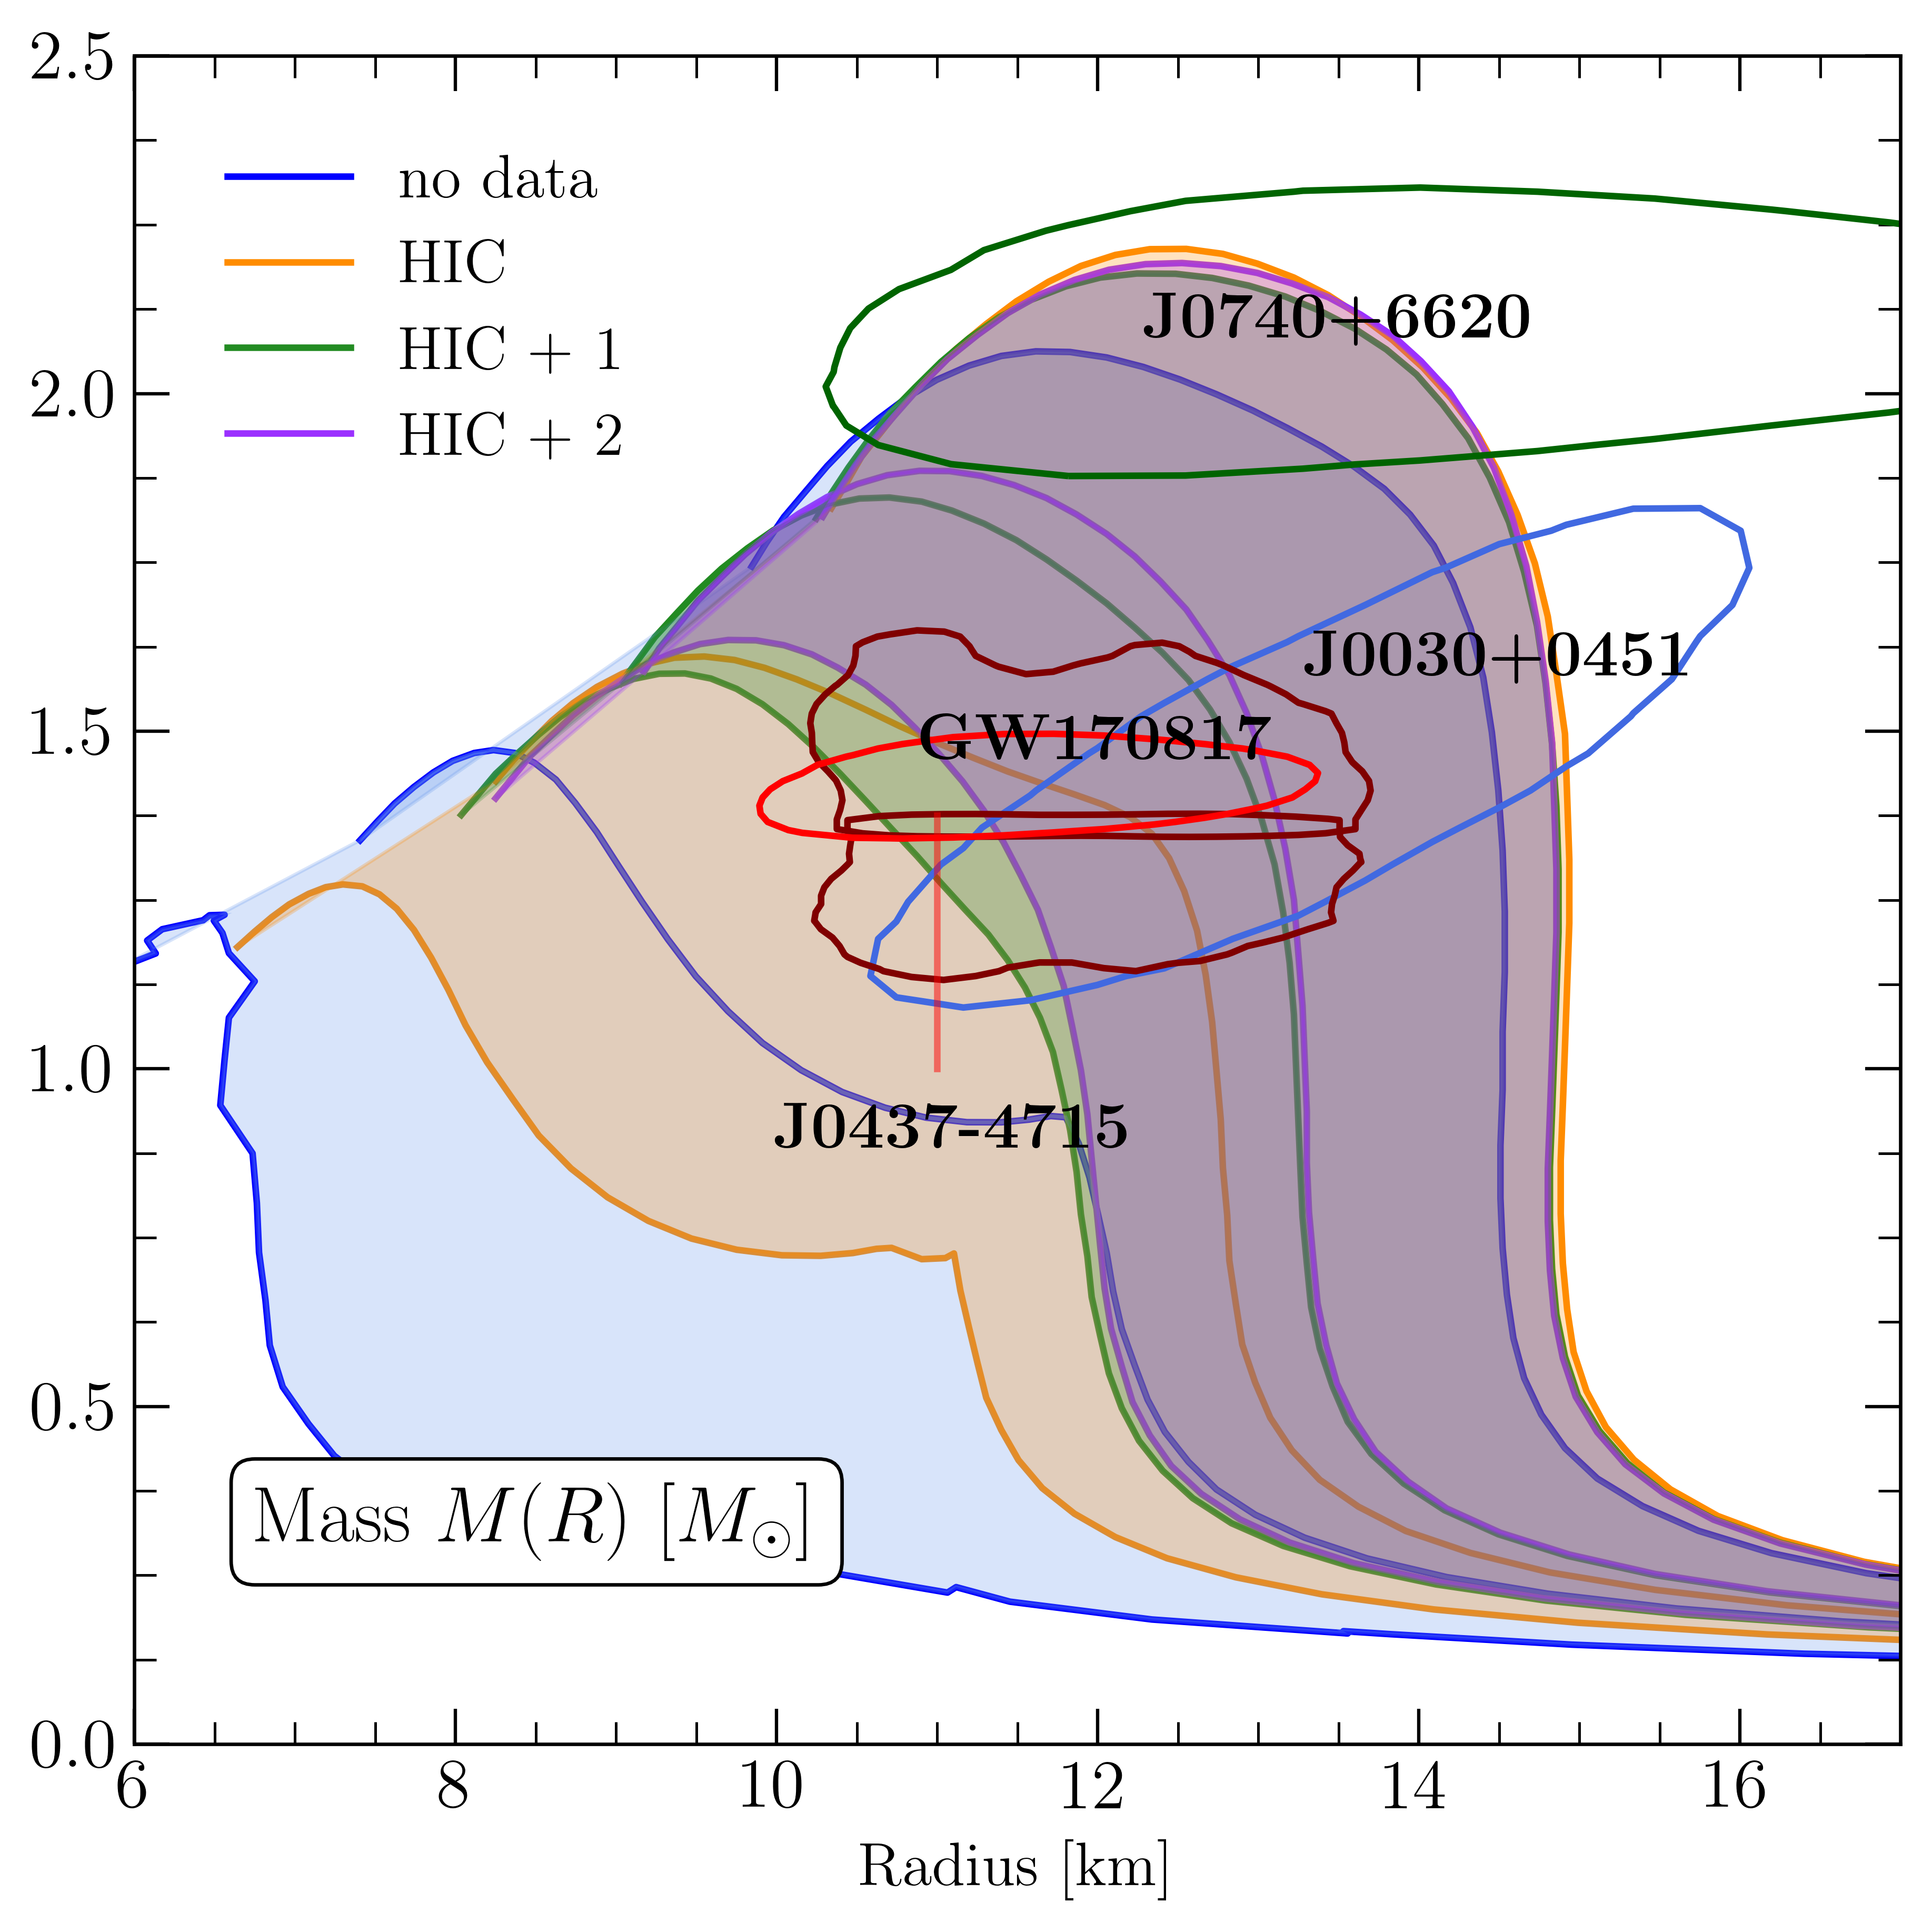

In [189]:
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon
import corner

royalpurple = '#9B30FF'

# plot the results including the samples and the overall mean, std_dev
fig = plt.figure(figsize=(6,6), dpi=600)
ax = plt.axes()

# means
ax.plot(radno, massno, color='blue', zorder=-5, label=r'no data')
ax.plot(radhicno, masshicno, color='darkorange', zorder=-4, label=r'HIC')
ax.plot(radhic1no, masshic1no, color='forestgreen', zorder=-3, label=r'HIC + 1')
ax.plot(radhic2no, masshic2no, color=royalpurple, zorder=-2, label=r'HIC + 2')

# spline no data 
vertices = [(x, y1_val) for x, y1_val in zip(radno[:,1], massno[:,1])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radno[:,2]), reversed(massno[:,2]))]
vertices2 = [(x, y1_val) for x, y1_val in zip(radno[:,0], massno[:,0])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radno[:,1]), reversed(massno[:,1]))]

# hic point
verticeshic = [(x, y1_val) for x, y1_val in zip(radhicno[:,1], masshicno[:,1])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radhicno[:,2]), reversed(masshicno[:,2]))]
vertices2hic = [(x, y1_val) for x, y1_val in zip(radhicno[:,0], masshicno[:,0])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radhicno[:,1]), reversed(masshicno[:,1]))]

# hic point + 1
verticeshic1 = [(x, y1_val) for x, y1_val in zip(radhic1no[:,1], masshic1no[:,1])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radhic1no[:,2]), reversed(masshic1no[:,2]))]
vertices2hic1 = [(x, y1_val) for x, y1_val in zip(radhic1no[:,0], masshic1no[:,0])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radhic1no[:,1]), reversed(masshic1no[:,1]))]

# hic point + 2
verticeshic2 = [(x, y1_val) for x, y1_val in zip(radhic2no[:,1], masshic2no[:,1])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radhic2no[:,2]), reversed(masshic2no[:,2]))]
vertices2hic2 = [(x, y1_val) for x, y1_val in zip(radhic2no[:,0], masshic2no[:,0])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radhic2no[:,1]), reversed(masshic2no[:,1]))]

polygon = Polygon(vertices, closed=True, color="cornflowerblue", alpha=0.25)
polygon2 = Polygon(vertices2, closed=True, color="cornflowerblue", alpha=0.25)
plt.gca().add_patch(polygon)
plt.gca().add_patch(polygon2)

polygonhic = Polygon(verticeshic, closed=True, color="darkorange", alpha=0.25)
polygon2hic = Polygon(vertices2hic, closed=True, color="darkorange", alpha=0.25)
plt.gca().add_patch(polygonhic)
plt.gca().add_patch(polygon2hic)

polygonhic1 = Polygon(verticeshic1, closed=True, color='forestgreen', alpha=0.25)
polygon2hic1 = Polygon(vertices2hic1, closed=True, color='forestgreen', alpha=0.25)
plt.gca().add_patch(polygonhic1)
plt.gca().add_patch(polygon2hic1)

polygonhic2 = Polygon(verticeshic2, closed=True, color=royalpurple, alpha=0.25)
polygon2hic2 = Polygon(vertices2hic2, closed=True, color=royalpurple, alpha=0.25)
plt.gca().add_patch(polygonhic2)
plt.gca().add_patch(polygon2hic2)

handles, labels = plt.gca().get_legend_handles_labels()

# NICER and LIGO contours
corner.hist2d(miller[:,0], miller[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.8, ax=ax, color='darkgreen', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=False)
corner.hist2d(miller_0030_2[:,0], miller_0030_2[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.8, ax=ax, color='royalblue', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=False)
corner.hist2d(x11, y11, bins=30, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=1.1, ax=ax, color='maroon', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=False)
corner.hist2d(x22, y22, bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.9, ax=ax, color='maroon', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=False)
corner.hist2d(j0437[:,2], j0437[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=j0437[:,0], \
              levels=[0.9], smooth=0.8, ax=ax, color='red', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=False)
    
# labels for LIGO and NICER data
ax.text(13.5, 2.15, r'$\textbf{J0740+6620}$', zorder=100, ha='center', va='top', fontsize=15)
ax.text(14.5, 1.65, r'$\textbf{J0030+0451}$', zorder=100, ha='center', va='top', fontsize=15)

# remove duplicates by converting to a dictionary
unique = dict(zip(labels, handles))
legend = ax.legend(unique.values(), unique.keys(), fontsize=14, frameon=False, bbox_to_anchor=[0.32, 0.985])

# GW 190814
ax.text(12.0, 1.525, r'$\textbf{GW170817}$', ha='center', va='top', fontsize=15, zorder=10)
ax.axvline(x=11.0, ymin=0.4, ymax=0.55, color='red', alpha=0.5)
ax.text(11.1, 0.95, r'$\textbf{J0437-4715}$', ha='center', va='top', fontsize=15)

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.125))
ax.tick_params(axis='both', which='major', labelsize=16, right=True, top=True, length=8)
ax.tick_params(axis='both', which='minor', labelsize=16, right=True, top=True, length=5)
ax.set_xlim(6.0, 17.0)
ax.set_ylim(0.0,2.5)
ax.set_xlabel(r'Radius [km]', fontsize=14)
ax.text(6.75, 0.30, r'Mass $M(R)$ $[M_\odot]$', fontsize=18, bbox=dict(facecolor='w', boxstyle='round'))
fig.savefig('../figures/ANM_Figures/comparison_MR_no_spline_sigmoid_HIC_FRG_3.pdf')
plt.show()

All right, this looks good! We can move this over to another notebook where we can calculate the central densities and other quantities from the EOS.

---
---